# Work with EU Data

In [50]:
import pandas as pd
import xgboost as xgb
from functools import reduce
import numpy as np 
from numpy import polyfit, polyval
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import graphviz

## Load all Data ##

In [2]:
path = "data/"
df_bus_age = pd.read_csv(path+ 'road_eqs_busage_linear_2_0.csv')
df_bus_motor = pd.read_csv(path+ 'road_eqs_busmot_linear_2_0.csv')
df_car_age = pd.read_csv(path+ 'road_eqs_carage_linear_2_0.csv')
df_car_motor = pd.read_csv(path+ 'road_eqs_carmot_linear_2_0.csv')
df_gdp_per_capita = pd.read_csv(path+ 'sdg_08_10_linear_2_0.csv')
df_pop = pd.read_csv(path+ 'tps00001_population.csv') # Only since 2014
df_pop_density = pd.read_csv(path+ 'tps00003_pop_density.csv') # Only since 2012
df_pop_age = pd.read_csv(path+ 'tps00010_pop_age.csv') # Only since 2013
df_modal_share = pd.read_csv(path+ 'tran_hv_psmod_linear_2_0.csv')
df_aq = pd.read_csv(path+ 'who_ambient_air_quality_database_version_2024_(v6.1)(Update 2024 (V6.csv')

In [3]:
def standardize_country_name(name):
    replacements = {
        "Netherlands (Kingdom of the)": "Netherlands",
        "T√ºrkiye": "Türkiye",
        "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
        "Metropolitan France": "France",
        "Russian Federation": "Russia"
    }
    return replacements.get(name, name)

In [4]:
def pivot_eurostat(df, pivot_colum, time = "TIME_PERIOD", location = "Geopolitical entity (reporting)", value = "OBS_VALUE"):
    df_filtered = df[df[time] >= 2010]
    df_pivot = df_filtered.pivot_table(
    index=[location, time],
    columns=pivot_colum,
    values=value
    )
    df_pivot = df_pivot.reset_index()
    df_pivot[location] = df_pivot[location].apply(standardize_country_name)
    return df_pivot

In [5]:
df_bus_age_clean = pivot_eurostat(df = df_bus_age, pivot_colum = 'age')
df_bus_age_clean.drop('Y_GE10', axis=1, inplace=True)
df_bus_age_clean.columns = ['Country', 'Year', 'Bus_age_Total', 'Bus_age_10-20', 'Bus_age_2-5', 'Bus_age_5-10','Bus_age_GT_20','Bus_age_LT_2']
df_bus_age_clean

Country  Year  Bus_age_Total  Bus_age_10-20  Bus_age_2-5  \
0           Albania  2013         5676.0            NaN          NaN   
1           Albania  2014         6048.0         2424.0        187.0   
2           Albania  2015         6421.0         2672.0        150.0   
3           Albania  2016         7049.0         2941.0        135.0   
4           Albania  2017         6583.0         3254.0         95.0   
..              ...   ...            ...            ...          ...   
585  United Kingdom  2017       158432.0        59556.0      25943.0   
586  United Kingdom  2018       154990.0        59394.0      26583.0   
587  United Kingdom  2021       140675.0        55845.0      22658.0   
588  United Kingdom  2022       138108.0        56197.0      19483.0   
589  United Kingdom  2023       136170.0        56357.0      16062.0   

     Bus_age_5-10  Bus_age_GT_20  Bus_age_LT_2  
0             NaN            NaN           NaN  
1           331.0         3035.0          71.0  
2           411.0         3108.0          80.0  
3           587.0         3289.0          97.0  
4           710.0         2423.0         101.0  
..            ...            ...           ...  
585       43103.0        11538.0       18292.0  
586       40424.0        12200.0       16389.0  
587       40437.0        12557.0        9178.0  
588       40582.0        13554.0        8292.0  
589       39762.0        14279.0        9710.0  

[590 rows x 8 columns]

In [6]:
df_bus_motor_clean = pivot_eurostat(df = df_bus_motor, pivot_colum = 'Motor energy')
df_bus_motor_clean = df_bus_motor_clean[['Geopolitical entity (reporting)', 'TIME_PERIOD', 'Diesel', 'Petroleum products', 'Liquefied petroleum gases (LPG)', 'Natural gas', 'Electricity']]
df_bus_motor_clean.columns = ['Country', 'Year', 'Bus_Diesel', 'Bus_Petroleum', 'Bus_LPG', 'Bus_Natural_Gas', 'Bus_Electricity']
df_bus_motor_clean

Country  Year  Bus_Diesel  Bus_Petroleum  Bus_LPG  \
0           Albania  2013         NaN            NaN      NaN   
1           Albania  2014      6037.0            7.0      NaN   
2           Albania  2015      6411.0            8.0      NaN   
3           Albania  2016      7036.0            8.0      0.0   
4           Albania  2017      6572.0            6.0      0.0   
..              ...   ...         ...            ...      ...   
490  United Kingdom  2017    153797.0         4001.0      NaN   
491  United Kingdom  2018    150252.0         3862.0      NaN   
492  United Kingdom  2021    135360.0         3496.0      NaN   
493  United Kingdom  2022    132218.0         3409.0      NaN   
494  United Kingdom  2023    129243.0         3232.0      NaN   

     Bus_Natural_Gas  Bus_Electricity  
0                NaN              NaN  
1                NaN              NaN  
2                NaN              NaN  
3                2.0              0.0  
4                4.0              0.0  
..               ...              ...  
490              NaN            305.0  
491              NaN            510.0  
492            460.0           1327.0  
493            483.0           1929.0  
494            440.0           3188.0  

[495 rows x 7 columns]

In [7]:
df_car_age_clean = pivot_eurostat(df = df_bus_age, pivot_colum = 'age').drop('Y_GE10', axis=1)
df_car_age_clean.columns = ['Country', 'Year', 'Car_age_Total', 'Car_age_10-20', 'Car_age_2-5', 'Car_age_5-10','Car_age_GT_20','Car_age_LT_2']
df_car_age_clean


Country  Year  Car_age_Total  Car_age_10-20  Car_age_2-5  \
0           Albania  2013         5676.0            NaN          NaN   
1           Albania  2014         6048.0         2424.0        187.0   
2           Albania  2015         6421.0         2672.0        150.0   
3           Albania  2016         7049.0         2941.0        135.0   
4           Albania  2017         6583.0         3254.0         95.0   
..              ...   ...            ...            ...          ...   
585  United Kingdom  2017       158432.0        59556.0      25943.0   
586  United Kingdom  2018       154990.0        59394.0      26583.0   
587  United Kingdom  2021       140675.0        55845.0      22658.0   
588  United Kingdom  2022       138108.0        56197.0      19483.0   
589  United Kingdom  2023       136170.0        56357.0      16062.0   

     Car_age_5-10  Car_age_GT_20  Car_age_LT_2  
0             NaN            NaN           NaN  
1           331.0         3035.0          71.0  
2           411.0         3108.0          80.0  
3           587.0         3289.0          97.0  
4           710.0         2423.0         101.0  
..            ...            ...           ...  
585       43103.0        11538.0       18292.0  
586       40424.0        12200.0       16389.0  
587       40437.0        12557.0        9178.0  
588       40582.0        13554.0        8292.0  
589       39762.0        14279.0        9710.0  

[590 rows x 8 columns]

In [8]:
df_car_motor_clean = pivot_eurostat(df = df_car_motor, pivot_colum = 'Motor energy')
df_car_motor_clean.columns = ['Country', 'Year', 'Car_Diesel', 'Car_Petroleum', 'Car_motor_Total']
df_car_motor_clean['Car_Renewable'] = df_car_motor_clean['Car_motor_Total'] - df_car_motor_clean['Car_Diesel'] - df_car_motor_clean['Car_Petroleum']
df_car_motor_clean

Country  Year  Car_Diesel  Car_Petroleum  Car_motor_Total  \
0           Albania  2013         NaN            NaN         341691.0   
1           Albania  2014   272421.00      101259.00         378053.0   
2           Albania  2015   292461.00      103607.00         403630.0   
3           Albania  2016   317053.00      104016.00         435613.0   
4           Albania  2017   300905.00       95112.00         417426.0   
..              ...   ...         ...            ...              ...   
591  United Kingdom  2017  6168915.25     9362672.25       31200182.0   
592  United Kingdom  2018  6188968.50     9498351.75       31517597.0   
593  United Kingdom  2021  5807997.50     9702355.25       31878624.0   
594  United Kingdom  2022  5625861.50    10115678.00       32169932.0   
595  United Kingdom  2023  5377712.50    10405755.75       32546013.0   

     Car_Renewable  
0              NaN  
1          4373.00  
2          7562.00  
3         14544.00  
4         21409.00  
..             ...  
591    15668594.50  
592    15830276.75  
593    16368271.25  
594    16428392.50  
595    16762544.75  

[596 rows x 6 columns]

In [9]:
df_gdp_per_capita_clean = df_gdp_per_capita[['Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE']]
df_gdp_per_capita_clean.columns = ['Country', 'Year', 'GDP per capita']
df_gdp_per_capita_clean = df_gdp_per_capita_clean[df_gdp_per_capita_clean['Year'] >= 2010]
df_gdp_per_capita_clean['Country'] = df_gdp_per_capita_clean['Country'].apply(standardize_country_name)
df_gdp_per_capita_clean

Country  Year  GDP per capita
10           Albania  2010          3800.0
11           Albania  2011          3910.0
12           Albania  2012          3950.0
13           Albania  2013          4030.0
14           Albania  2014          4130.0
...              ...   ...             ...
1887  United Kingdom  2015             1.6
1888  United Kingdom  2016             0.9
1889  United Kingdom  2017             1.1
1890  United Kingdom  2018             0.6
1891  United Kingdom  2019             0.8

[1140 rows x 3 columns]

In [10]:
df_pop_clean = df_pop[['Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE']]
df_pop_clean.columns = ['Country', 'Year', 'Population']
df_pop_clean['Country'] = df_pop_clean['Country'].apply(standardize_country_name)
df_pop_clean

C:\Users\arbei\AppData\Local\Temp\ipykernel_20268\3848619253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pop_clean['Country'] = df_pop_clean['Country'].apply(standardize_country_name)


Country  Year  Population
0    Andorra  2016       71732
1    Andorra  2018       74794
2    Andorra  2019       76177
3    Andorra  2020       77543
4    Andorra  2022       79535
..       ...   ...         ...
575  Kosovo*  2018     1798506
576  Kosovo*  2019     1795666
577  Kosovo*  2020     1782115
578  Kosovo*  2021     1798186
579  Kosovo*  2022     1773971

[580 rows x 3 columns]

In [11]:
df_pop_density_clean = df_pop_density[['Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE']]
df_pop_density_clean.columns = ['Country', 'Year', 'Population_density']
df_pop_density_clean['Country'] = df_pop_density_clean['Country'].apply(standardize_country_name)
df_pop_density_clean

C:\Users\arbei\AppData\Local\Temp\ipykernel_20268\1710783752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pop_density_clean['Country'] = df_pop_density_clean['Country'].apply(standardize_country_name)


Country  Year  Population_density
0           Albania  2012               100.7
1           Albania  2013               100.6
2           Albania  2014               100.4
3           Albania  2015               100.1
4           Albania  2016                99.9
..              ...   ...                 ...
436  United Kingdom  2015               268.5
437  United Kingdom  2016               270.6
438  United Kingdom  2017               272.4
439  United Kingdom  2018               273.8
440  United Kingdom  2020               275.3

[441 rows x 3 columns]

In [12]:
df_pop_age_clean = pivot_eurostat(df = df_pop_age, pivot_colum = 'indic_de')
df_pop_age_clean.columns = ['Country', 'Year', 'Pop_age_0-14', 'Pop_age_15-24', 'Pop_age_25-49', 'Pop_age_50-64', 'Pop_age_65-79', 'Pop_age_GT_80']
df_pop_age_clean

Country  Year  Pop_age_0-14  Pop_age_15-24  Pop_age_25-49  \
0           Albania  2013          20.1           18.2           32.0   
1           Albania  2014          19.6           17.9           32.0   
2           Albania  2015          19.0           17.5           32.0   
3           Albania  2016          18.5           17.1           32.3   
4           Albania  2017          18.2           16.5           32.6   
..              ...   ...           ...            ...            ...   
539  United Kingdom  2015          17.7           12.6           33.6   
540  United Kingdom  2016          17.7           12.4           33.4   
541  United Kingdom  2017          17.8           12.1           33.2   
542  United Kingdom  2018          17.9           11.9           33.0   
543  United Kingdom  2019          17.9           11.8           32.8   

     Pop_age_50-64  Pop_age_65-79  Pop_age_GT_80  
0             18.1            9.6            2.0  
1             18.6            9.9            2.1  
2             19.0           10.2            2.2  
3             19.3           10.5            2.3  
4             19.6           10.7            2.4  
..             ...            ...            ...  
539           18.4           13.0            4.8  
540           18.5           13.1            4.8  
541           18.7           13.2            4.9  
542           18.9           13.3            4.9  
543           19.1           13.4            5.0  

[544 rows x 8 columns]

In [13]:
df_modal_share_clean = pivot_eurostat(df = df_modal_share, pivot_colum = 'vehicle').drop(['TRN_BUS_TOT_AVD'], axis=1)
df_modal_share_clean.columns = ['Country', 'Year', 'Modal_Share_Bus', 'Modal_Share_Car', 'Modal_Share_Train']
df_modal_share_clean

Country  Year  Modal_Share_Bus  Modal_Share_Car  Modal_Share_Train
0           Austria  2010             10.4             77.9               11.7
1           Austria  2011             10.5             77.5               12.1
2           Austria  2012             10.0             78.2               11.8
3           Austria  2013              9.9             77.8               12.3
4           Austria  2014              9.9             77.9               12.2
..              ...   ...              ...              ...                ...
505  United Kingdom  2015              5.2             86.1                8.7
506  United Kingdom  2016              4.5             86.7                8.8
507  United Kingdom  2017              5.0             86.4                8.7
508  United Kingdom  2018              4.6             86.8                8.7
509  United Kingdom  2019              5.6             82.7               11.8

[510 rows x 5 columns]

In [14]:
df_aq_eu = df_aq[df_aq['who_region'] == '4_Eur']
df_aq_clean = df_aq_eu[['country_name', 'year', 'pm10_concentration', 'pm25_concentration', 'no2_concentration']]
df_aq_clean = df_aq_clean[df_aq_clean['year'] >= 2010]
df_aq_clean.columns = ['Country', 'Year', 'pm10_concentration', 'pm25_concentration', 'no2_concentration']
df_aq_clean_mean = df_aq_clean.groupby(["Country", "Year"])[['pm10_concentration', 'pm25_concentration', 'no2_concentration']].mean()
df_aq_clean_mean = df_aq_clean_mean.reset_index()
df_aq_clean_mean['Country'] = df_aq_clean_mean['Country'].apply(standardize_country_name)
df_aq_clean_mean

Country    Year  pm10_concentration  pm25_concentration  \
0           Albania  2014.0           28.181800           12.910750   
1           Albania  2015.0           25.467500           16.355750   
2           Albania  2016.0           26.074250           16.847500   
3           Albania  2017.0           28.301250           17.493750   
4           Albania  2018.0           33.516500           16.712500   
..              ...     ...                 ...                 ...   
400  United Kingdom  2018.0           16.015115            9.631000   
401  United Kingdom  2019.0           15.547070            9.603864   
402  United Kingdom  2020.0           14.644339            8.031304   
403      Uzbekistan  2018.0                 NaN           43.094000   
404      Uzbekistan  2019.0                 NaN           41.962000   

     no2_concentration  
0            22.387800  
1            18.094000  
2            17.044200  
3            17.376000  
4            19.212750  
..                 ...  
400          21.365400  
401          21.005248  
402          18.629457  
403                NaN  
404                NaN  

[405 rows x 5 columns]

## Join all datasets

In [15]:
# List of all cleaned dataframes to join
dfs = [
    df_bus_age_clean,
    df_bus_motor_clean,
    df_car_age_clean,
    df_car_motor_clean,
    df_gdp_per_capita_clean,
    df_pop_clean,
    df_pop_density_clean,
    df_pop_age_clean,
    df_modal_share_clean,
    df_aq_clean_mean
]

# Merge all dataframes on 'Country' and 'Year'
df_all = reduce(lambda left, right: pd.merge(left, right, on=['Country', 'Year'], how='outer'), dfs)
df_all

Country    Year  Bus_age_Total  Bus_age_10-20  Bus_age_2-5  \
0            Albania  2010.0            NaN            NaN          NaN   
1            Albania  2010.0            NaN            NaN          NaN   
2            Albania  2011.0            NaN            NaN          NaN   
3            Albania  2011.0            NaN            NaN          NaN   
4            Albania  2012.0            NaN            NaN          NaN   
...              ...     ...            ...            ...          ...   
1359  United Kingdom  2021.0       140675.0        55845.0      22658.0   
1360  United Kingdom  2022.0       138108.0        56197.0      19483.0   
1361  United Kingdom  2023.0       136170.0        56357.0      16062.0   
1362      Uzbekistan  2018.0            NaN            NaN          NaN   
1363      Uzbekistan  2019.0            NaN            NaN          NaN   

      Bus_age_5-10  Bus_age_GT_20  Bus_age_LT_2  Bus_Diesel  Bus_Petroleum  \
0              NaN            NaN           NaN         NaN            NaN   
1              NaN            NaN           NaN         NaN            NaN   
2              NaN            NaN           NaN         NaN            NaN   
3              NaN            NaN           NaN         NaN            NaN   
4              NaN            NaN           NaN         NaN            NaN   
...            ...            ...           ...         ...            ...   
1359       40437.0        12557.0        9178.0    135360.0         3496.0   
1360       40582.0        13554.0        8292.0    132218.0         3409.0   
1361       39762.0        14279.0        9710.0    129243.0         3232.0   
1362           NaN            NaN           NaN         NaN            NaN   
1363           NaN            NaN           NaN         NaN            NaN   

      ...  Pop_age_25-49  Pop_age_50-64  Pop_age_65-79  Pop_age_GT_80  \
0     ...            NaN            NaN            NaN            NaN   
1     ...            NaN            NaN            NaN            NaN   
2     ...            NaN            NaN            NaN            NaN   
3     ...            NaN            NaN            NaN            NaN   
4     ...            NaN            NaN            NaN            NaN   
...   ...            ...            ...            ...            ...   
1359  ...            NaN            NaN            NaN            NaN   
1360  ...            NaN            NaN            NaN            NaN   
1361  ...            NaN            NaN            NaN            NaN   
1362  ...            NaN            NaN            NaN            NaN   
1363  ...            NaN            NaN            NaN            NaN   

      Modal_Share_Bus  Modal_Share_Car  Modal_Share_Train  pm10_concentration  \
0                 NaN              NaN                NaN                 NaN   
1                 NaN              NaN                NaN                 NaN   
2                 NaN              NaN                NaN                 NaN   
3                 NaN              NaN                NaN                 NaN   
4                 NaN              NaN                NaN                 NaN   
...               ...              ...                ...                 ...   
1359              NaN              NaN                NaN                 NaN   
1360              NaN              NaN                NaN                 NaN   
1361              NaN              NaN                NaN                 NaN   
1362              NaN              NaN                NaN                 NaN   
1363              NaN              NaN                NaN                 NaN   

      pm25_concentration  no2_concentration  
0                    NaN                NaN  
1                    NaN                NaN  
2                    NaN                NaN  
3                    NaN                NaN  
4                    NaN                NaN  
...                  ...                ...  
135

### Delete ROWS with NA in important Places ###

In [16]:
df_all_clean = df_all.dropna(subset=['pm10_concentration', 'pm25_concentration', 'no2_concentration'], how='all')
df_all_clean = df_all_clean.dropna(subset=['Modal_Share_Bus', 'Modal_Share_Car', 'Modal_Share_Train'], how='all')
df_all_clean


Country    Year  Bus_age_Total  Bus_age_10-20  Bus_age_2-5  \
52           Austria  2010.0         9648.0            NaN       2098.0   
53           Austria  2010.0         9648.0            NaN       2098.0   
58           Austria  2013.0         9579.0         1880.0       2245.0   
59           Austria  2013.0         9579.0         1880.0       2245.0   
60           Austria  2014.0         9585.0         1899.0       1872.0   
...              ...     ...            ...            ...          ...   
1353  United Kingdom  2015.0       162696.0        58307.0      26774.0   
1354  United Kingdom  2016.0       161500.0        59212.0      26385.0   
1355  United Kingdom  2017.0       158432.0        59556.0      25943.0   
1356  United Kingdom  2018.0       154990.0        59394.0      26583.0   
1357  United Kingdom  2019.0            NaN            NaN          NaN   

      Bus_age_5-10  Bus_age_GT_20  Bus_age_LT_2  Bus_Diesel  Bus_Petroleum  \
52          3036.0            NaN        2324.0         NaN            NaN   
53          3036.0            NaN        2324.0         NaN            NaN   
58          3161.0          317.0        1976.0      8883.0            2.0   
59          3161.0          317.0        1976.0      8883.0            2.0   
60          3204.0          318.0        2292.0      8918.0            3.0   
...            ...            ...           ...         ...            ...   
1353       49244.0        10528.0       17843.0    157659.0         4531.0   
1354       45669.0        11032.0       19202.0    156757.0         4309.0   
1355       43103.0        11538.0       18292.0    153797.0         4001.0   
1356       40424.0        12200.0       16389.0    150252.0         3862.0   
1357           NaN            NaN           NaN         NaN            NaN   

      ...  Pop_age_25-49  Pop_age_50-64  Pop_age_65-79  Pop_age_GT_80  \
52    ...            NaN            NaN            NaN            NaN   
53    ...            NaN            NaN            NaN            NaN   
58    ...           35.8           19.7           13.1            5.0   
59    ...           35.8           19.7           13.1            5.0   
60    ...           35.5           20.0           13.3            5.0   
...   ...            ...            ...            ...            ...   
1353  ...           33.6           18.4           13.0            4.8   
1354  ...           33.4           18.5           13.1            4.8   
1355  ...           33.2           18.7           13.2            4.9   
1356  ...           33.0           18.9           13.3            4.9   
1357  ...           32.8           19.1           13.4            5.0   

      Modal_Share_Bus  Modal_Share_Car  Modal_Share_Train  pm10_concentration  \
52               10.4             77.9               11.7           23.169136   
53               10.4             77.9               11.7           23.169136   
58                9.9             77.8               12.3           20.139984   
59                9.9             77.8               12.3           20.139984   
60                9.9             77.9               12.2           18.240947   
...               ...              ...                ...                 ...   
1353              5.2             86.1                8.7           15.864308   
1354              4.5             86.7                8.8           15.998788   
1355              5.0             86.4                8.7           15.300830   
1356              4.6             86.8                8.7           16.015115   
1357              5.6             82.7               11.8           15.547070   

      pm25_concentration  no2_concentration  
52             18.357364          22.458091  
53             18.357364          22.458091  
58             15.660818          20.383615  
59             15.660818          20.383615  
60             12.987581          19.499727  
...                  ...                ...  
135

## Calculations ##
Normalize Values so the population size does not affect the changed variables

In [17]:
df_all_clean.describe()

Year  Bus_age_Total  Bus_age_10-20    Bus_age_2-5  \
count   688.000000     659.000000     512.000000     573.000000   
mean   2016.194767   39467.030349   16054.826172    6141.345550   
std       3.277976   99572.615827   39551.560995   15584.342177   
min    2010.000000     979.000000     112.000000      31.000000   
25%    2014.000000    5513.000000    1844.750000     611.000000   
50%    2016.000000   13886.000000    4313.000000    2087.000000   
75%    2019.000000   26834.000000   11047.250000    3944.000000   
max    2022.000000  706731.000000  263519.000000  112515.000000   

        Bus_age_5-10  Bus_age_GT_20  Bus_age_LT_2     Bus_Diesel  \
count     573.000000     424.000000    577.000000     508.000000   
mean     9718.815009    7277.179245   3889.450607   38350.557087   
std     24937.767552   24228.171780   7334.510030  103415.536587   
min       119.000000       0.000000      0.000000     950.000000   
25%      1011.000000     437.000000    452.000000    4656.000000   
50%      3388.000000    1292.500000   1681.000000   12589.500000   
75%      5382.000000    2518.000000   3428.000000   18628.000000   
max    193245.000000  182226.000000  61067.000000  688184.000000   

       Bus_Petroleum      Bus_LPG  ...  Pop_age_25-49  Pop_age_50-64  \
count     508.000000   436.000000  ...     609.000000     609.000000   
mean      536.281496    86.192661  ...      34.632677      19.900657   
std      1776.335520   220.766438  ...       2.032370       1.500899   
min         0.000000     0.000000  ...      30.600000      14.100000   
25%        14.000000     0.000000  ...      33.100000      19.100000   
50%        94.500000     5.000000  ...      34.300000      19.900000   
75%       287.000000    54.000000  ...      36.300000      20.900000   
max     12165.000000  1199.000000  ...      40.200000      23.000000   

       Pop_age_65-79  Pop_age_GT_80  Modal_Share_Bus  Modal_Share_Car  \
count     609.000000     609.000000       688.000000        688.00000   
mean       13.405747       4.686371        11.727471         82.97500   
std         1.978856       1.174060         5.598543          5.76878   
min         6.300000       1.700000         0.700000         59.30000   
25%        12.500000       4.000000         7.400000         80.00000   
50%        13.800000       4.700000        11.400000         83.10000   
75%        14.700000       5.500000        14.900000         86.40000   
max        18.300000       7.600000        38.300000         98.60000   

       Modal_Share_Train  pm10_concentration  pm25_concentration  \
count         632.000000          680.000000          634.000000   
mean            5.769937           23.823668           13.419610   
std             4.220126           10.863945            6.175615   
min             0.200000            4.013667            2.217000   
25%             2.200000           16.970053            9.241400   
50%             4.900000           21.112517           12.711200   
75%             8.600000           27.315157           16.471900   
max            20.000000           76.412357           45.341000   

       no2_concentration  
count         678.000000  
mean           17.176261  
std             5.913658  
min             0.570000  
25%            13.388023  
50%            17.356075  
75%            20.442570  
max            37.288125  

[8 rows x 37 columns]

In [18]:
df_all_clean_calc = df_all_clean.copy()
# Car Motor
df_all_clean_calc['Car_Renewable'] = df_all_clean_calc['Car_Renewable'] / df_all_clean_calc['Car_motor_Total'] * 100
df_all_clean_calc['Car_Petroleum'] = df_all_clean_calc['Car_Petroleum'] / df_all_clean_calc['Car_motor_Total'] * 100
df_all_clean_calc['Car_Diesel'] = df_all_clean_calc['Car_Diesel'] / df_all_clean_calc['Car_motor_Total'] * 100

# Car Age
df_all_clean_calc["Car_age_LT_2"] = df_all_clean_calc["Car_age_LT_2"] / df_all_clean_calc["Car_age_Total"] * 100
df_all_clean_calc["Car_age_2-5"] = df_all_clean_calc["Car_age_2-5"] / df_all_clean_calc["Car_age_Total"] * 100
df_all_clean_calc["Car_age_5-10"] = df_all_clean_calc["Car_age_5-10"] / df_all_clean_calc["Car_age_Total"] * 100
df_all_clean_calc["Car_age_10-20"] = df_all_clean_calc["Car_age_10-20"] / df_all_clean_calc["Car_age_Total"] * 100
df_all_clean_calc["Car_age_GT_20"] = df_all_clean_calc["Car_age_GT_20"] / df_all_clean_calc["Car_age_Total"] * 100

# Bus Motor
df_all_clean_calc['Bus_motor_Total'] = df_all_clean_calc['Bus_Diesel'] + df_all_clean_calc['Bus_Petroleum'] + df_all_clean_calc['Bus_LPG'] + df_all_clean_calc['Bus_Natural_Gas'] + df_all_clean_calc['Bus_Electricity']
df_all_clean_calc['Bus_LPG'] = df_all_clean_calc['Bus_LPG'] / df_all_clean_calc['Bus_motor_Total'] * 100
df_all_clean_calc['Bus_Petroleum'] = df_all_clean_calc['Bus_Petroleum'] / df_all_clean_calc['Bus_motor_Total'] * 100
df_all_clean_calc['Bus_Diesel'] = df_all_clean_calc['Bus_Diesel'] / df_all_clean_calc['Bus_motor_Total'] * 100
df_all_clean_calc['Bus_Natural_Gas'] = df_all_clean_calc['Bus_Natural_Gas'] / df_all_clean_calc['Bus_motor_Total'] * 100
df_all_clean_calc['Bus_Electricity'] = df_all_clean_calc['Bus_Electricity'] / df_all_clean_calc['Bus_motor_Total'] * 100

# Bus Age
df_all_clean_calc["Bus_age_LT_2"] = df_all_clean_calc["Bus_age_LT_2"] / df_all_clean_calc["Bus_age_Total"] * 100
df_all_clean_calc["Bus_age_2-5"] = df_all_clean_calc["Bus_age_2-5"] / df_all_clean_calc["Bus_age_Total"] * 100
df_all_clean_calc["Bus_age_5-10"] = df_all_clean_calc["Bus_age_5-10"] / df_all_clean_calc["Bus_age_Total"] * 100
df_all_clean_calc["Bus_age_10-20"] = df_all_clean_calc["Bus_age_10-20"] / df_all_clean_calc["Bus_age_Total"] * 100
df_all_clean_calc["Bus_age_GT_20"] = df_all_clean_calc["Bus_age_GT_20"] / df_all_clean_calc["Bus_age_Total"] * 100

# Total transport per capita.
df_all_clean_calc['Car_age_Total'] = df_all_clean_calc['Car_age_Total'] / df_all_clean_calc['Population'] * 100
df_all_clean_calc['Bus_age_Total'] = df_all_clean_calc['Bus_age_Total'] / df_all_clean_calc['Population'] * 100


In [19]:
df_all_clean_calc.describe()

Year  Bus_age_Total  Bus_age_10-20  Bus_age_2-5  Bus_age_5-10  \
count   688.000000     526.000000     512.000000   573.000000    573.000000   
mean   2016.194767       0.240019      38.626137    14.720303     23.796647   
std       3.277976       0.154005      15.879114     7.385221      7.838755   
min    2010.000000       0.051989       5.705553     1.097867      6.890699   
25%    2014.000000       0.142550      30.865856     9.396591     17.656676   
50%    2016.000000       0.208511      37.475733    14.099978     22.859327   
75%    2019.000000       0.287289      47.635662    19.530516     30.060120   
max    2022.000000       0.914736      88.662593    35.880196     43.787835   

       Bus_age_GT_20  Bus_age_LT_2  Bus_Diesel  Bus_Petroleum     Bus_LPG  \
count     424.000000    577.000000  382.000000     382.000000  382.000000   
mean       13.919777     11.760712   94.450635       1.211141    0.185268   
std        10.197440      7.304201    5.767057       1.763300    0.532762   
min         0.000000      0.000000   70.094002       0.000000    0.000000   
25%         4.232066      6.262394   92.606825       0.163100    0.000000   
50%        13.550320     10.485934   95.897477       0.385711    0.019897   
75%        21.327731     14.936344   98.822280       1.255594    0.148844   
max        48.771339     33.780055   99.887006       8.230618    3.956985   

       ...  Pop_age_50-64  Pop_age_65-79  Pop_age_GT_80  Modal_Share_Bus  \
count  ...     609.000000     609.000000     609.000000       688.000000   
mean   ...      19.900657      13.405747       4.686371        11.727471   
std    ...       1.500899       1.978856       1.174060         5.598543   
min    ...      14.100000       6.300000       1.700000         0.700000   
25%    ...      19.100000      12.500000       4.000000         7.400000   
50%    ...      19.900000      13.800000       4.700000        11.400000   
75%    ...      20.900000      14.700000       5.500000        14.900000   
max    ...      23.000000      18.300000       7.600000        38.300000   

       Modal_Share_Car  Modal_Share_Train  pm10_concentration  \
count        688.00000         632.000000          680.000000   
mean          82.97500           5.769937           23.823668   
std            5.76878           4.220126           10.863945   
min           59.30000           0.200000            4.013667   
25%           80.00000           2.200000           16.970053   
50%           83.10000           4.900000           21.112517   
75%           86.40000           8.600000           27.315157   
max           98.60000          20.000000           76.412357   

       pm25_concentration  no2_concentration  Bus_motor_Total  
count          634.000000         678.000000       382.000000  
mean            13.419610          17.176261     43859.068063  
std              6.175615           5.913658    119793.214970  
min              2.217000           0.570000      1705.000000  
25%              9.241400          13.388023      5558.250000  
50%             12.711200          17.356075     13416.000000  
75%             16.471900          20.442570     19403.000000  
max             45.341000          37.288125    703249.000000  

[8 rows x 38 columns]

## Plots ##

In [20]:
def plot_pollutant_vs_x(df, pollutant, split):
    print(f"Plotting {pollutant}")
    fig_height = (len(split)//3)+1
    if len(split) <= 3:
        fig, axes = plt.subplots(1, len(split), figsize=(15, 4), sharey=True)
    elif len(split) % 3 == 0:
        fig, axes = plt.subplots(len(split)//3, 3, figsize=(6*(len(split)//3), (6*(len(split)//3))*2/3), sharey=True)
    else:
        fig, axes = plt.subplots(fig_height, 3, figsize=(6*fig_height, (6*fig_height)*2/3), sharey=True)
    corrs = {}

    axes_flat = axes.flatten() if hasattr(axes, "flatten") else np.array([axes])

    for i, type_split in enumerate(split):
        mask = ~df[type_split].isna() & ~df[pollutant].isna()
        sc = axes_flat[i].scatter(df[type_split][mask], df[pollutant][mask], c=df["Year"][mask], cmap="viridis", alpha=0.6)
        coef = polyfit(df[type_split][mask], df[pollutant][mask], 1)
        x = np.linspace(df[type_split].min(), df[type_split].max(), 100)
        axes_flat[i].plot(x, polyval(coef, x), color="red", label="Regression line")
        axes_flat[i].set_xlabel(type_split)
        axes_flat[i].set_title(f"{type_split} vs {pollutant.upper()}")
        axes_flat[i].legend()
        corr = df[type_split][mask].corr(df[pollutant][mask])
        corrs[type_split] = corr

    # cbar = plt.colorbar(sc, ax=axes, orientation="horizontal", pad=0.2)
    # cbar.set_label("Year", labelpad=15, loc="left")
    plt.tight_layout()
    plt.show()
    return corrs

In [21]:
correlation_results_propultion = {}
correlation_results_type_age = {}
correlation_results_modal_share = {}
correlation_results_Total_transport = {}
correlation_results_POP_Age = {}
correlation_results_GDP = {}

### Transport Propultion Type ###

Plotting pm25_concentration


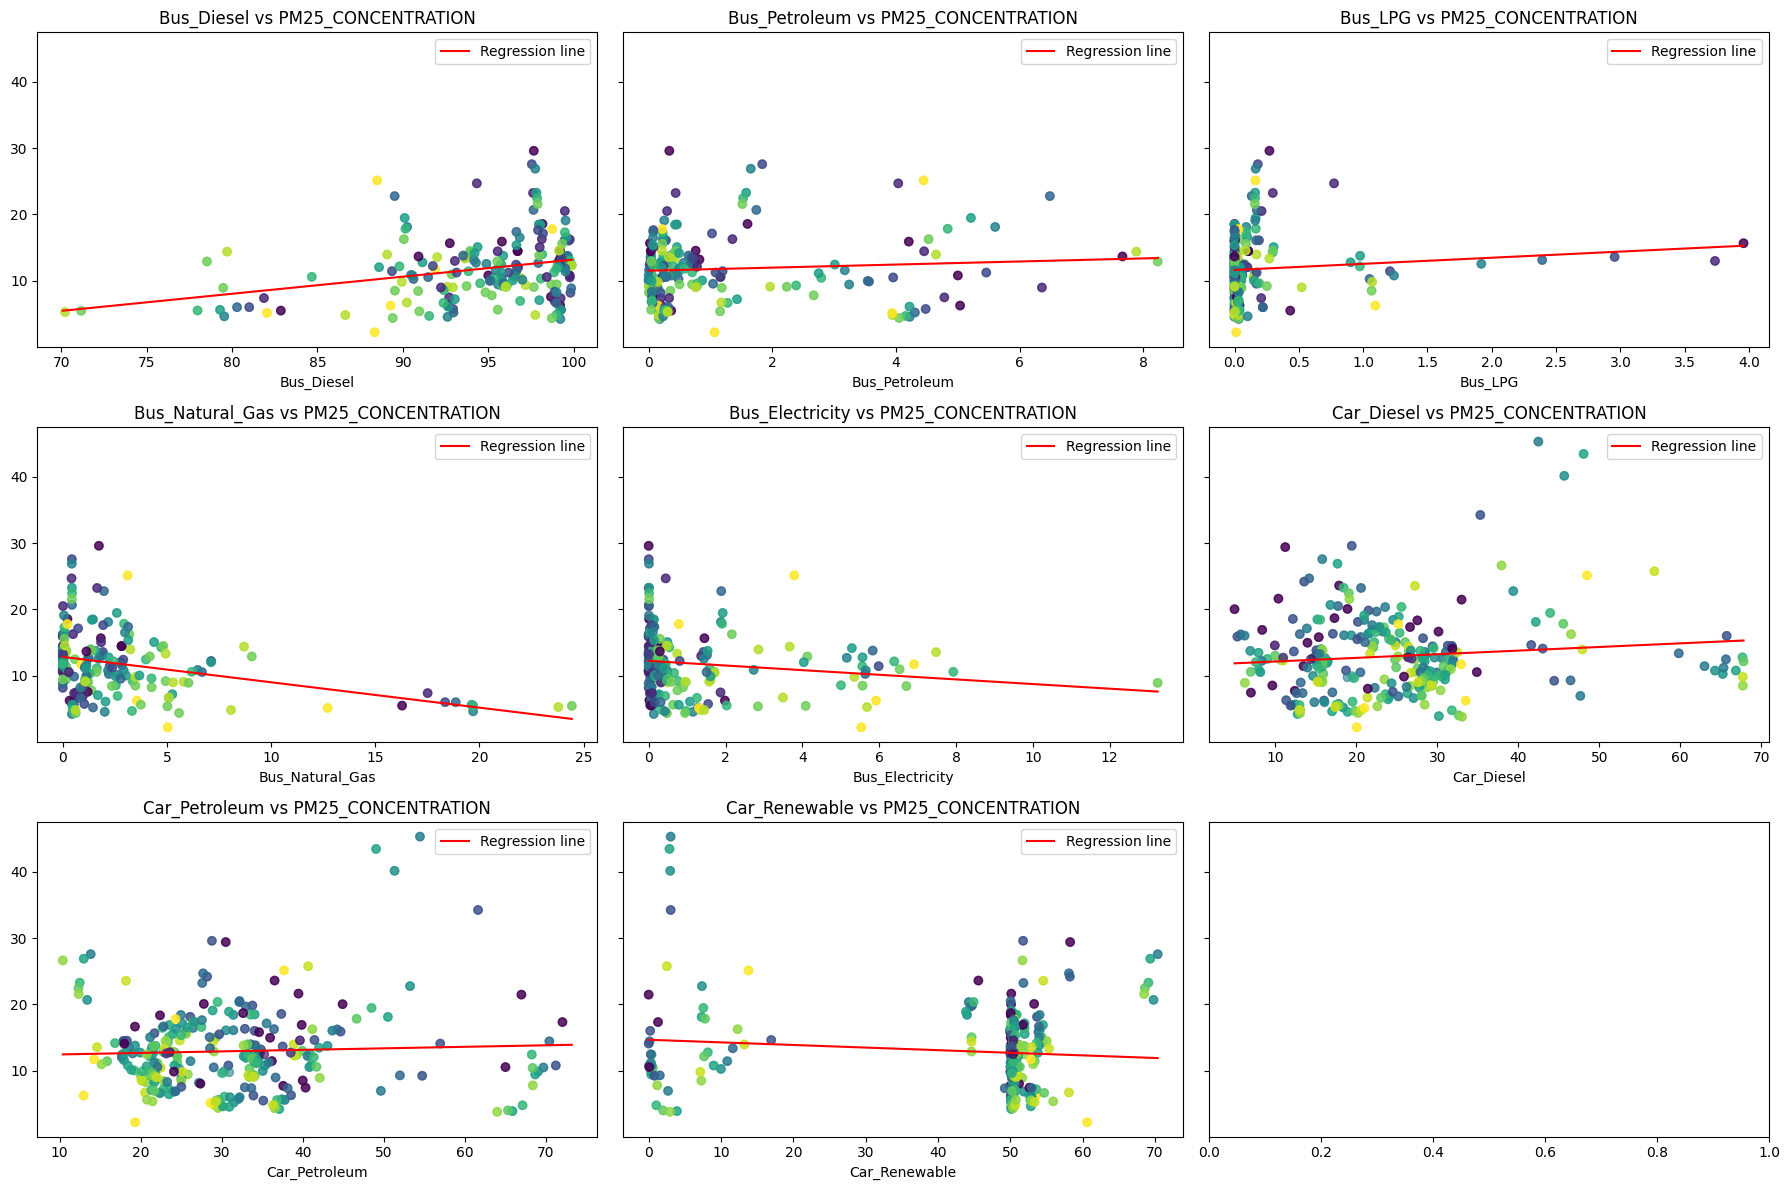

Plotting pm10_concentration


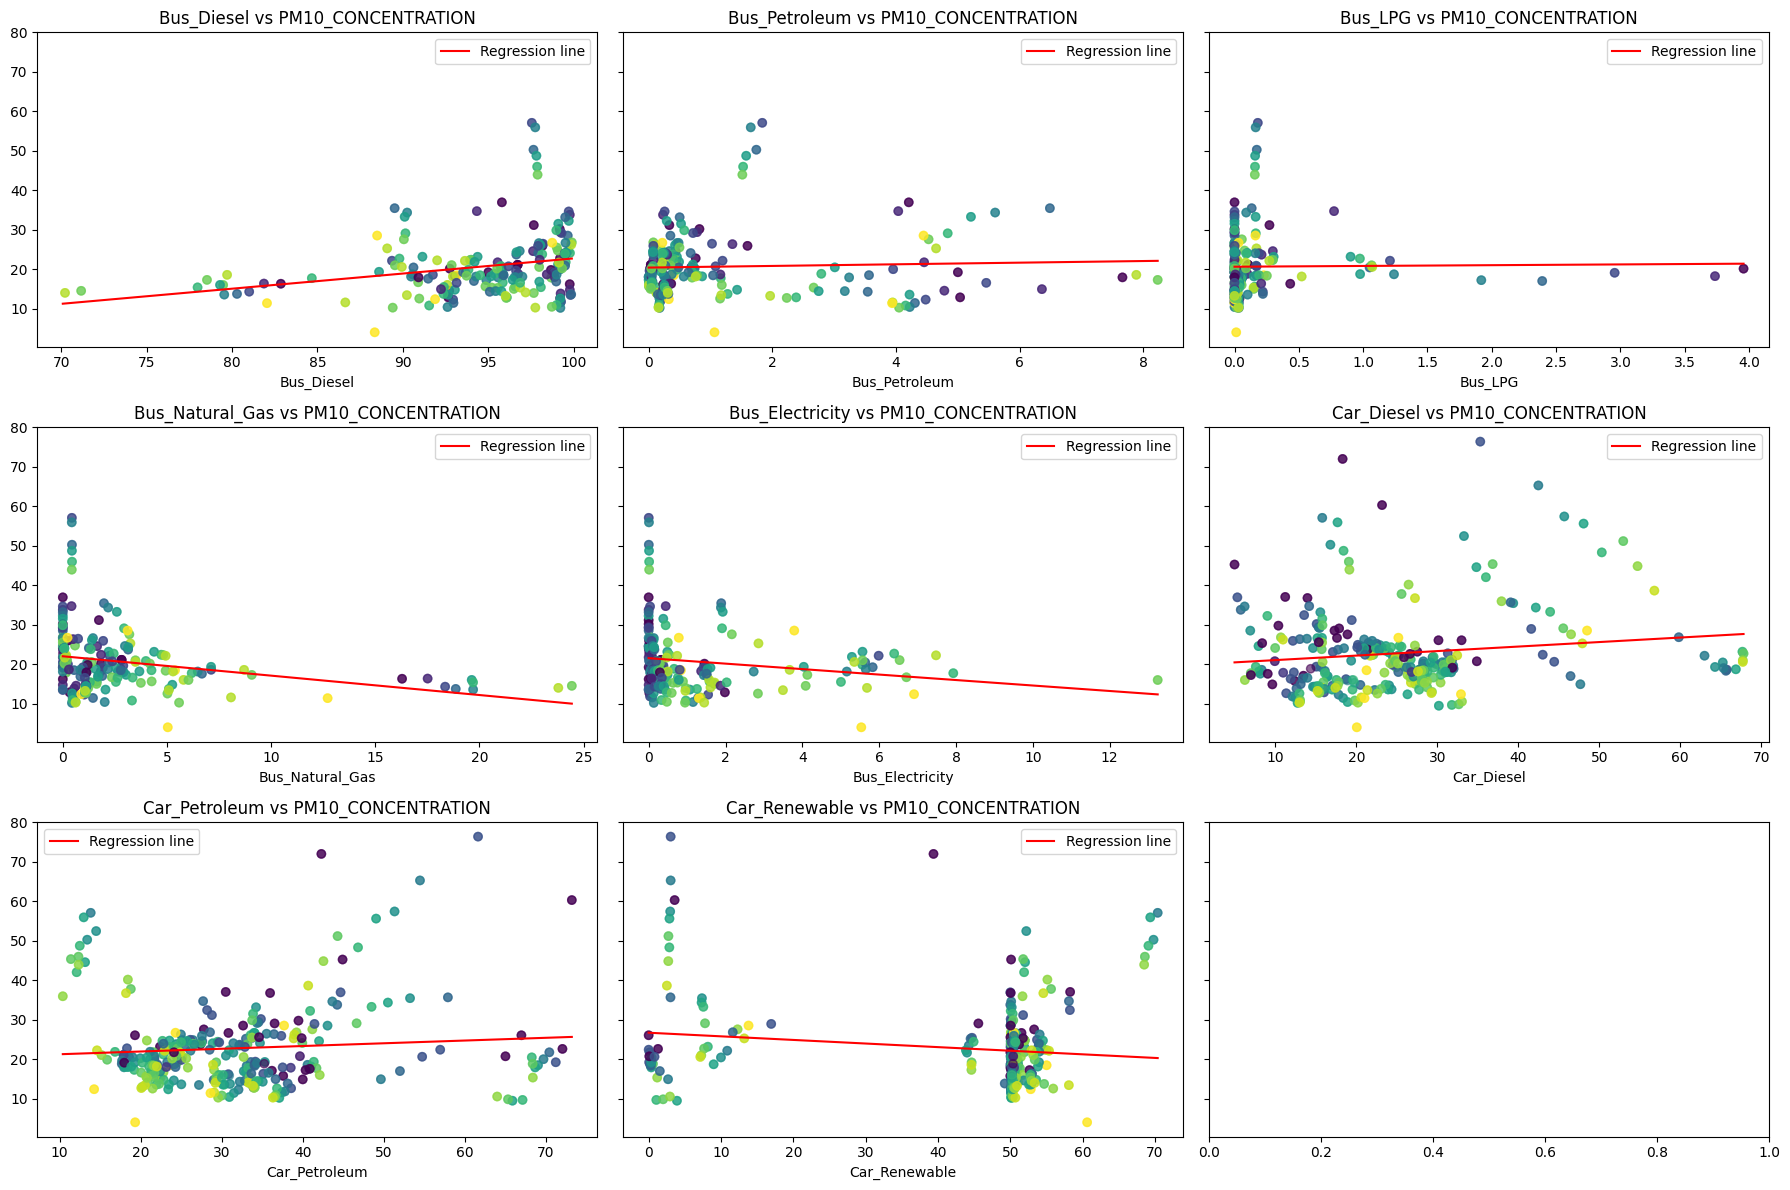

Plotting no2_concentration


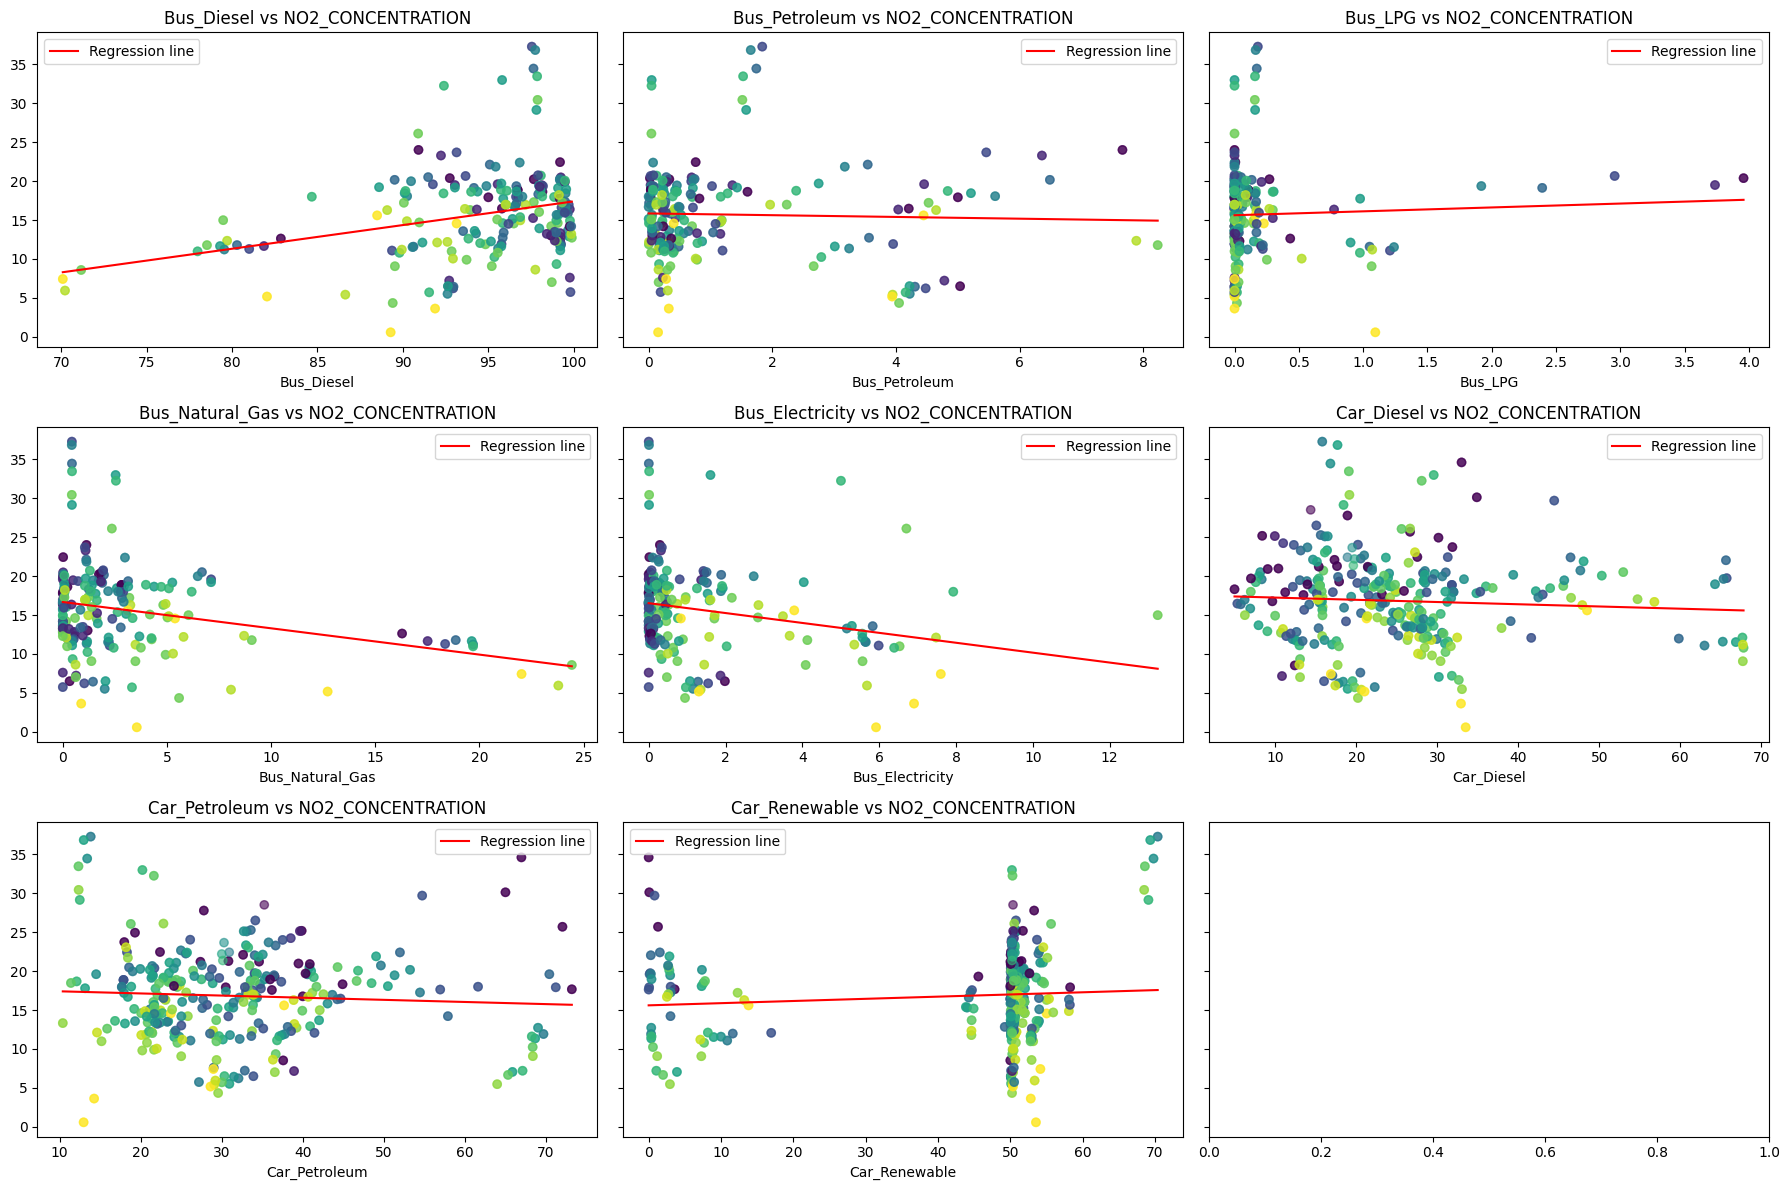

In [22]:
motor_transport = ['Bus_Diesel', 'Bus_Petroleum', 'Bus_LPG', 'Bus_Natural_Gas', 'Bus_Electricity','Car_Diesel', 'Car_Petroleum', 'Car_Renewable']

correlation_results_propultion['pm25']=plot_pollutant_vs_x(df_all_clean_calc, "pm25_concentration", motor_transport)
correlation_results_propultion['pm10']=plot_pollutant_vs_x(df_all_clean_calc, "pm10_concentration", motor_transport)
correlation_results_propultion['no2']=plot_pollutant_vs_x(df_all_clean_calc, "no2_concentration", motor_transport)

### Transport Age Type ###

Plotting pm25_concentration


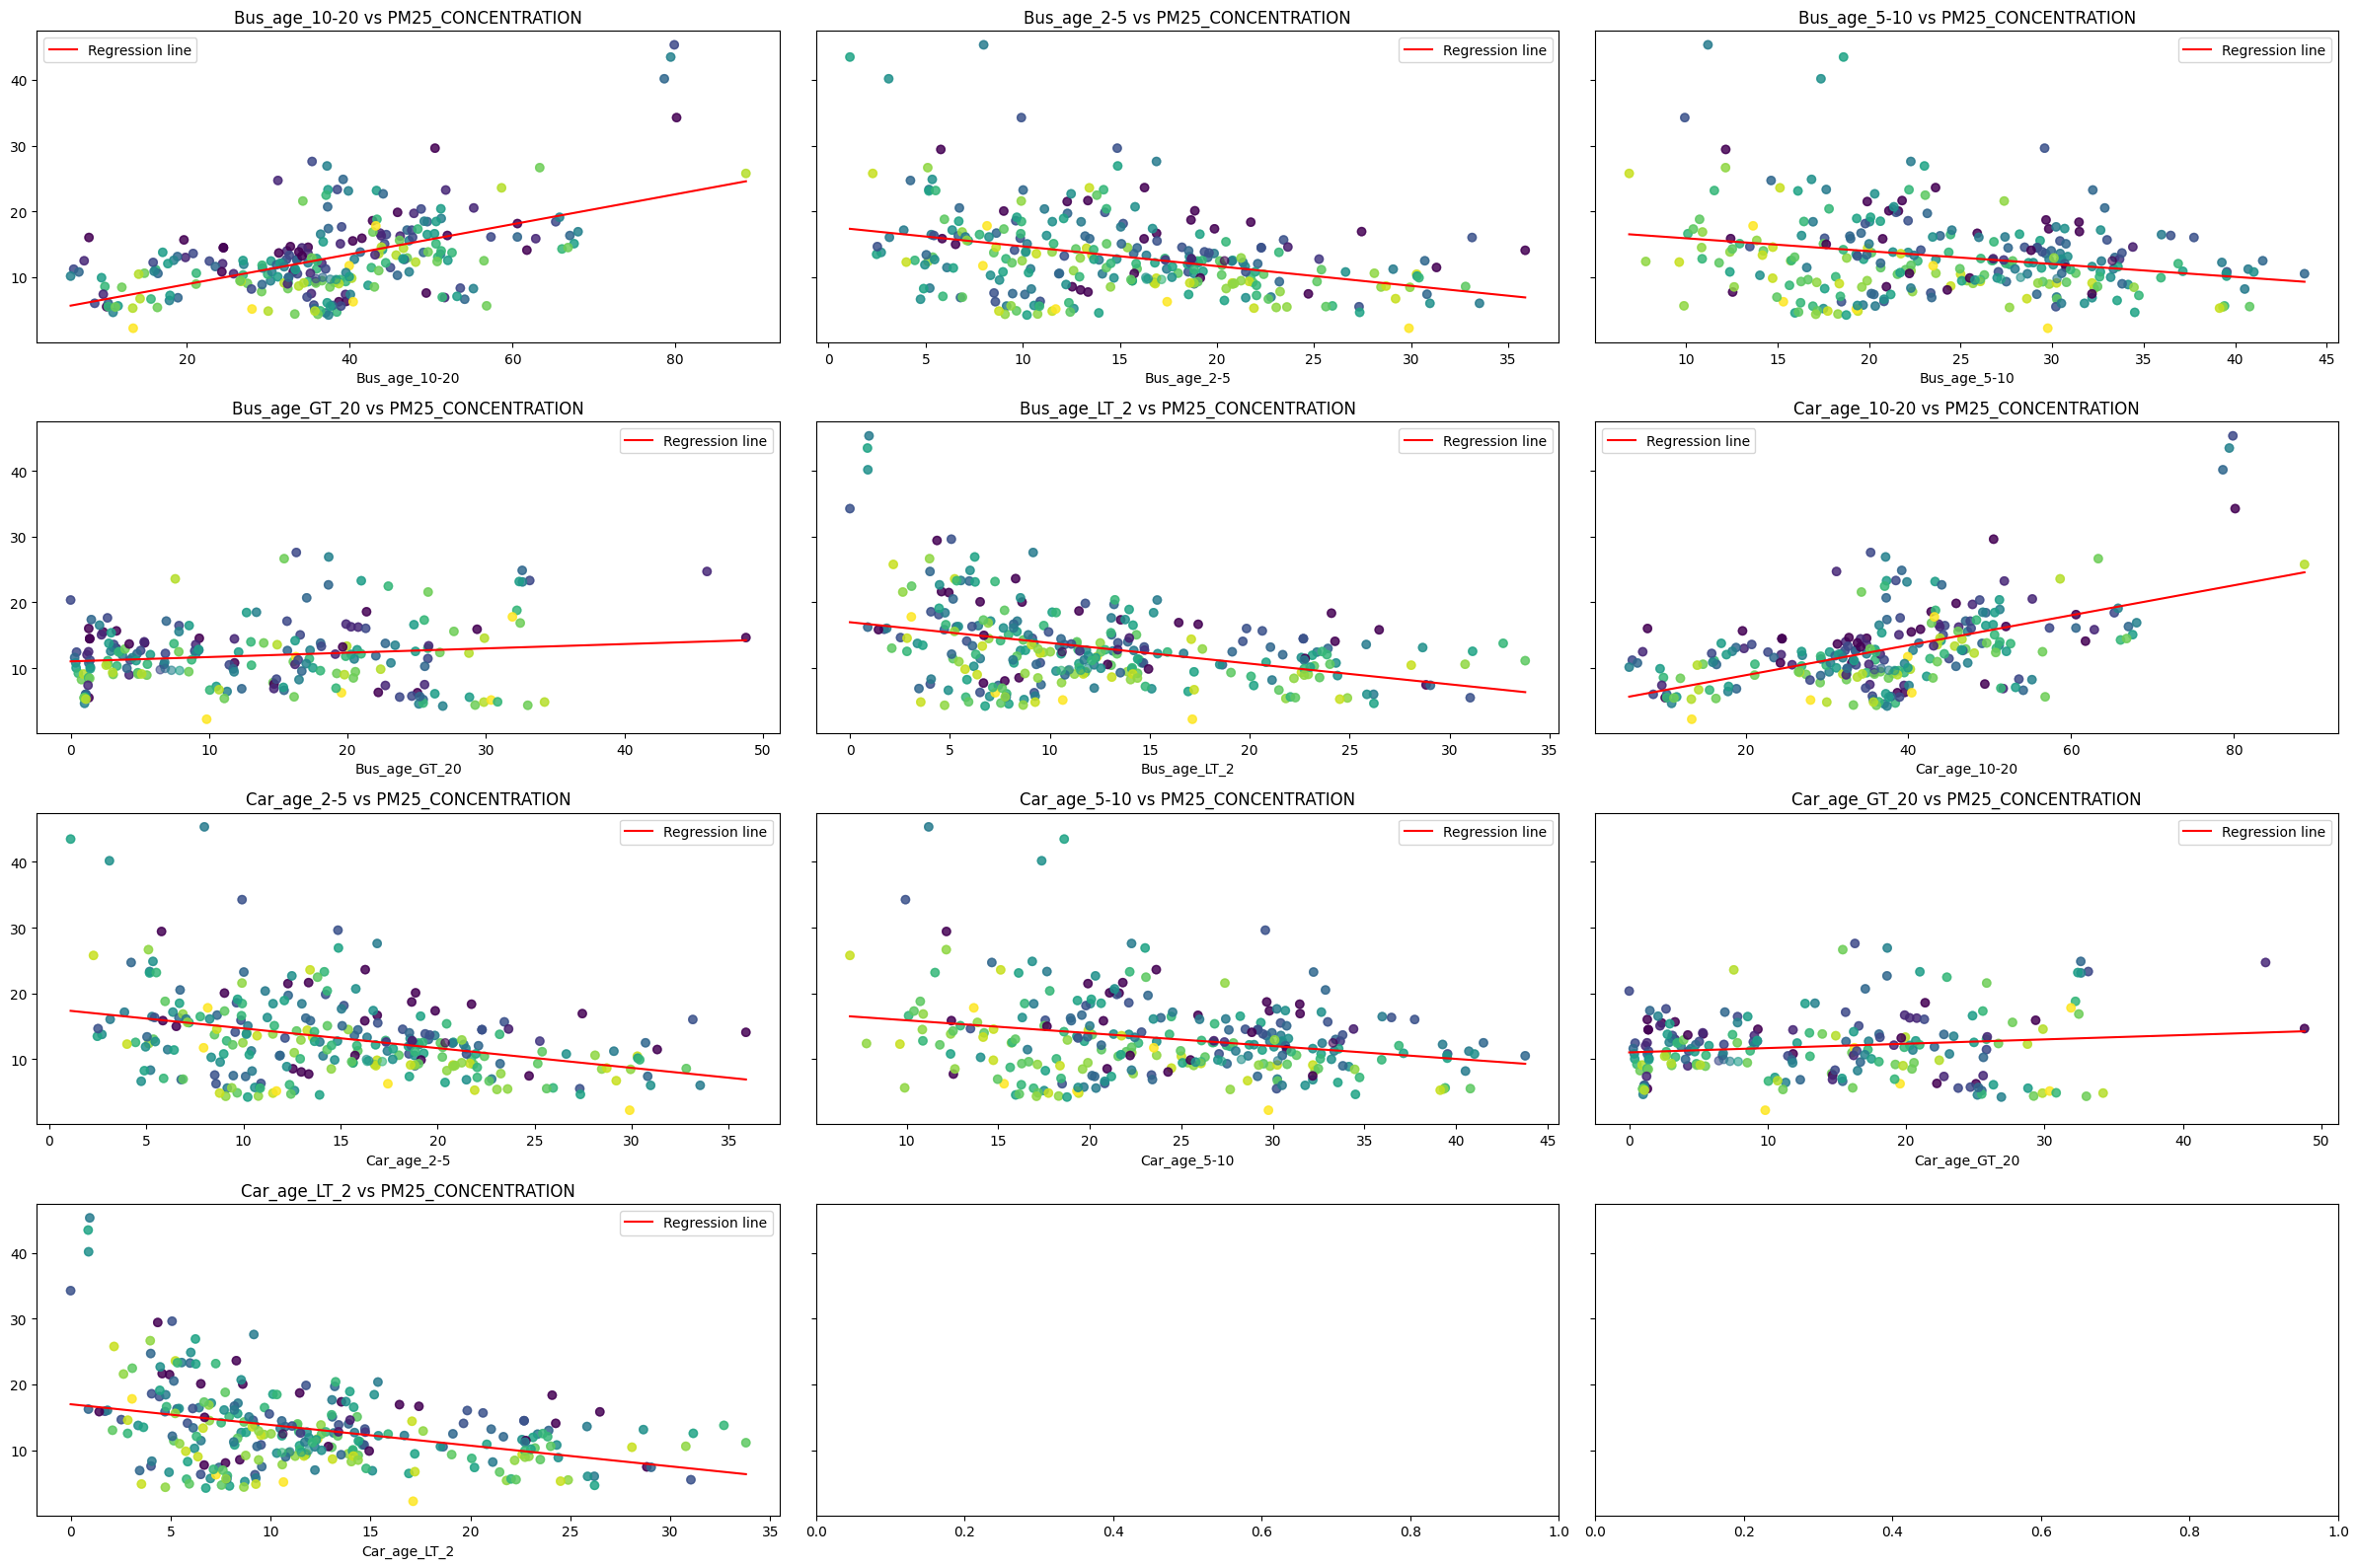

Plotting pm10_concentration


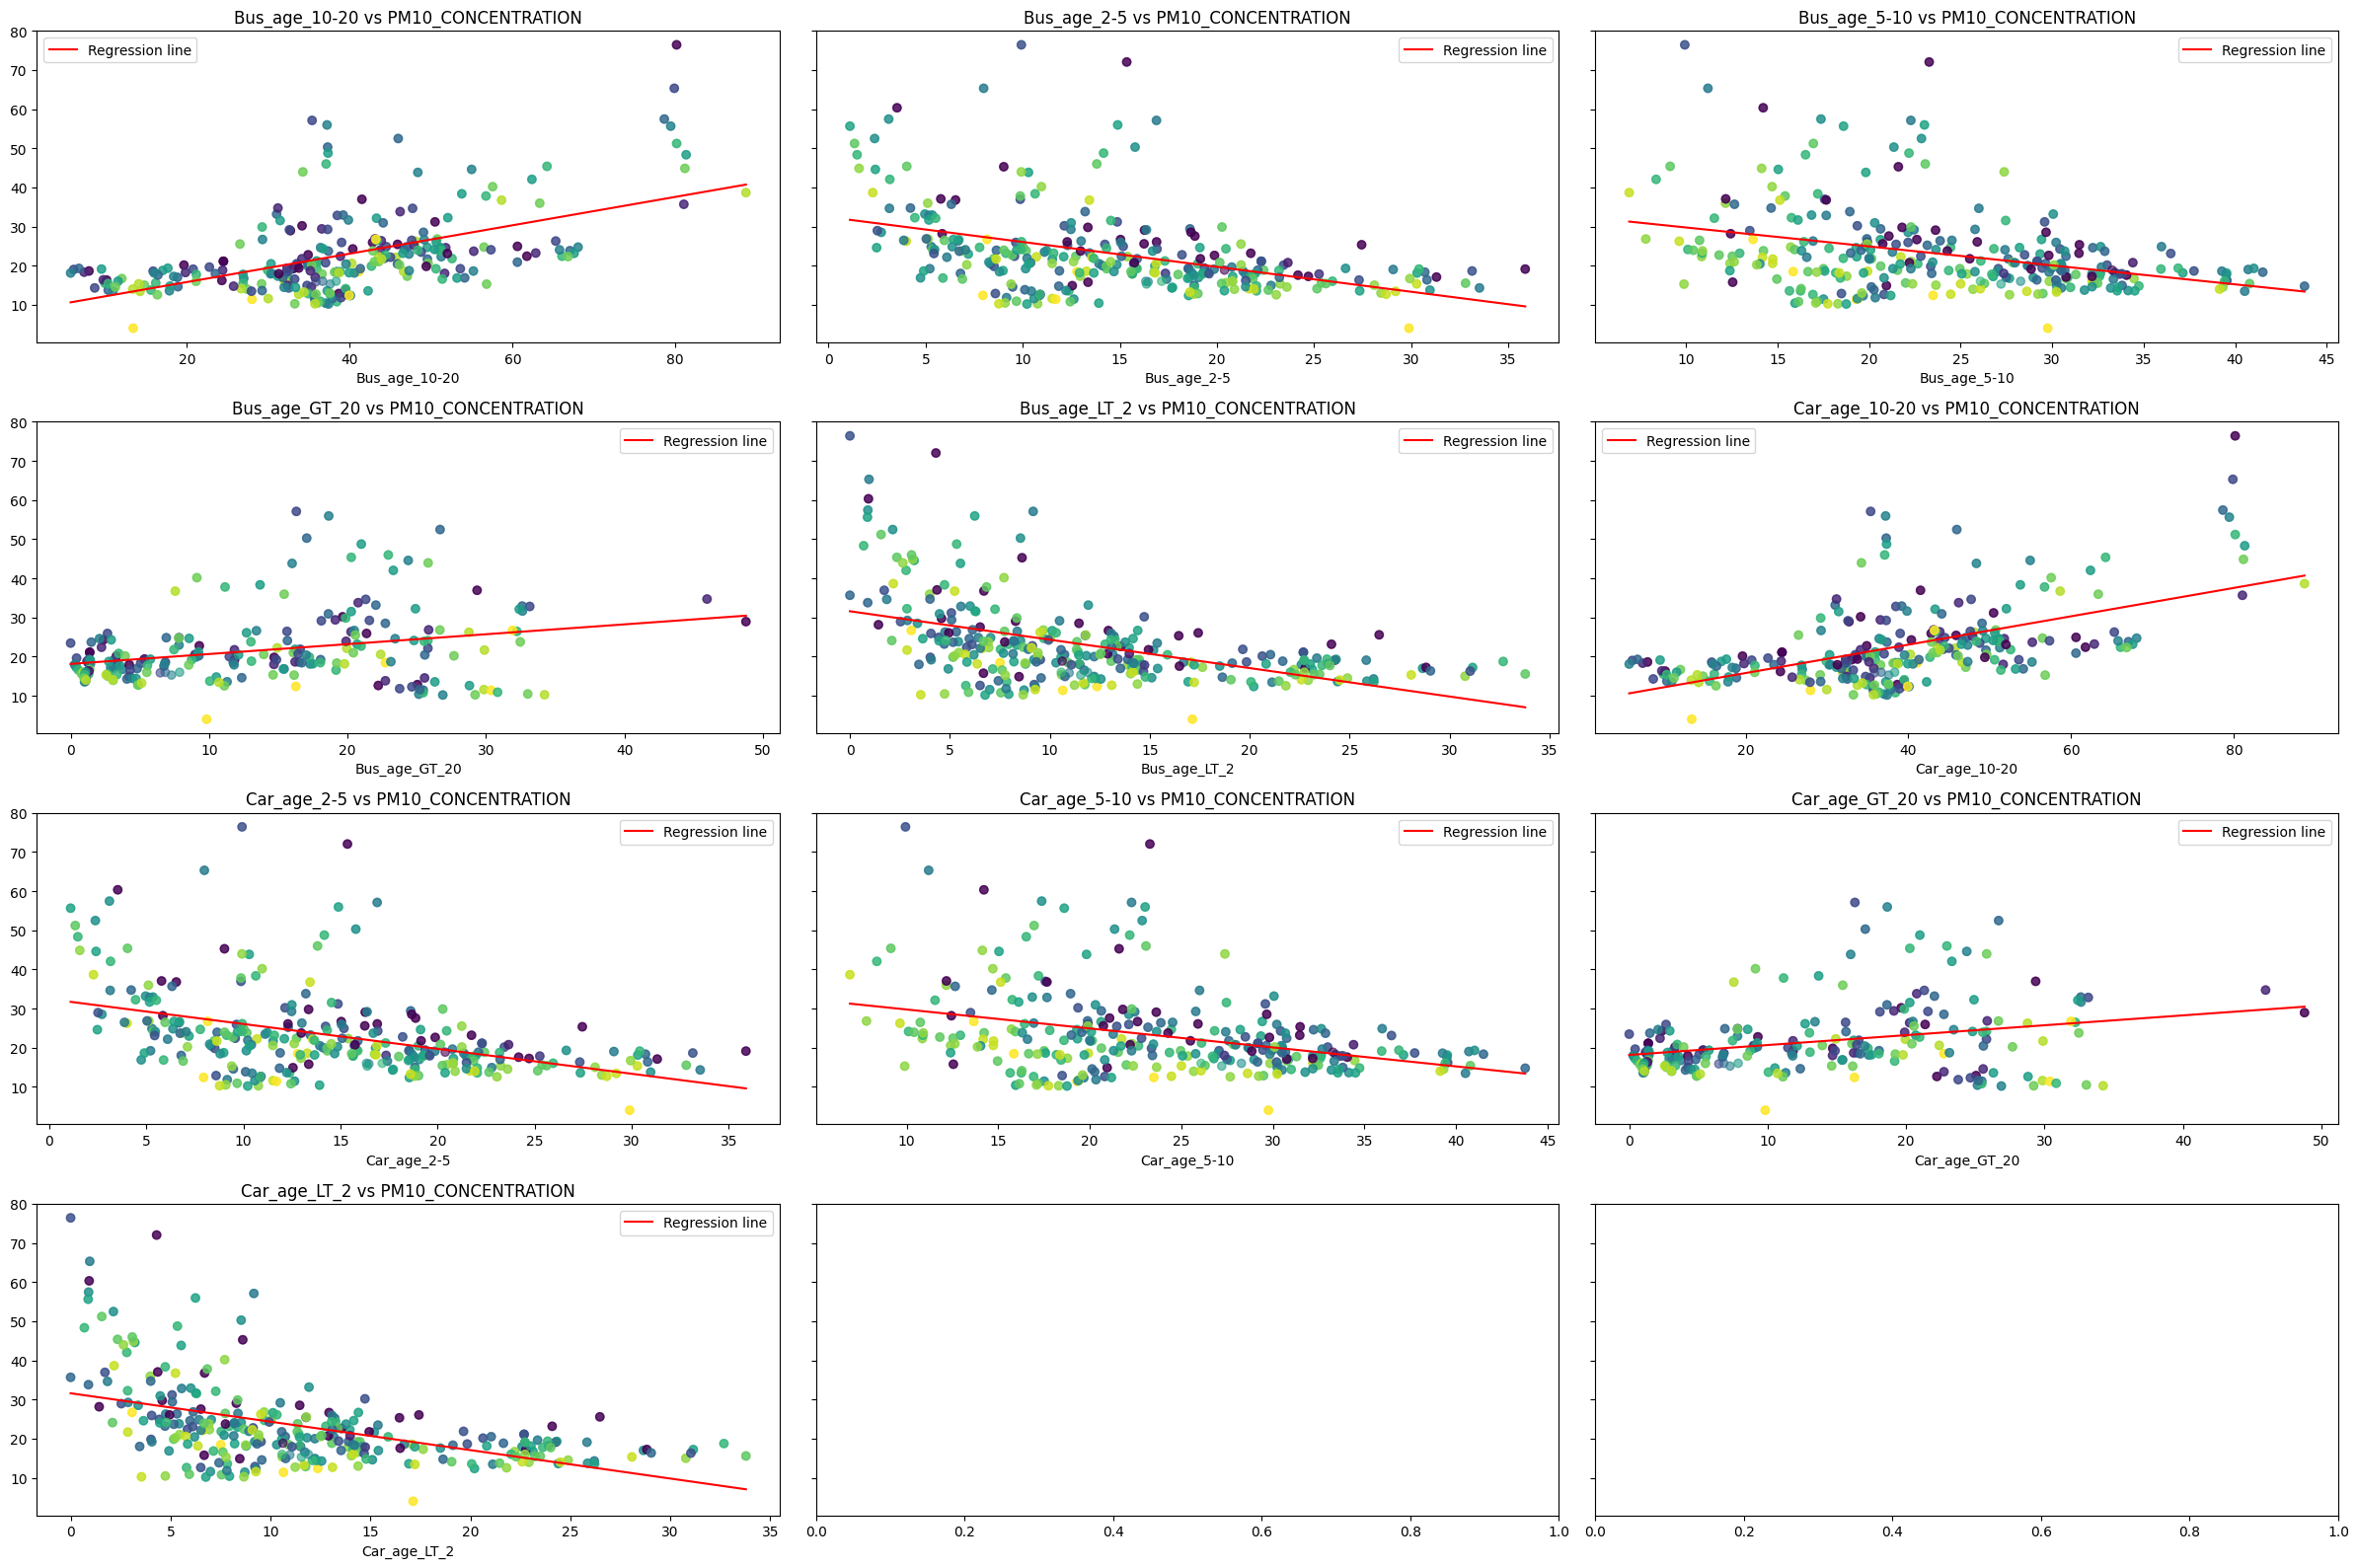

Plotting no2_concentration


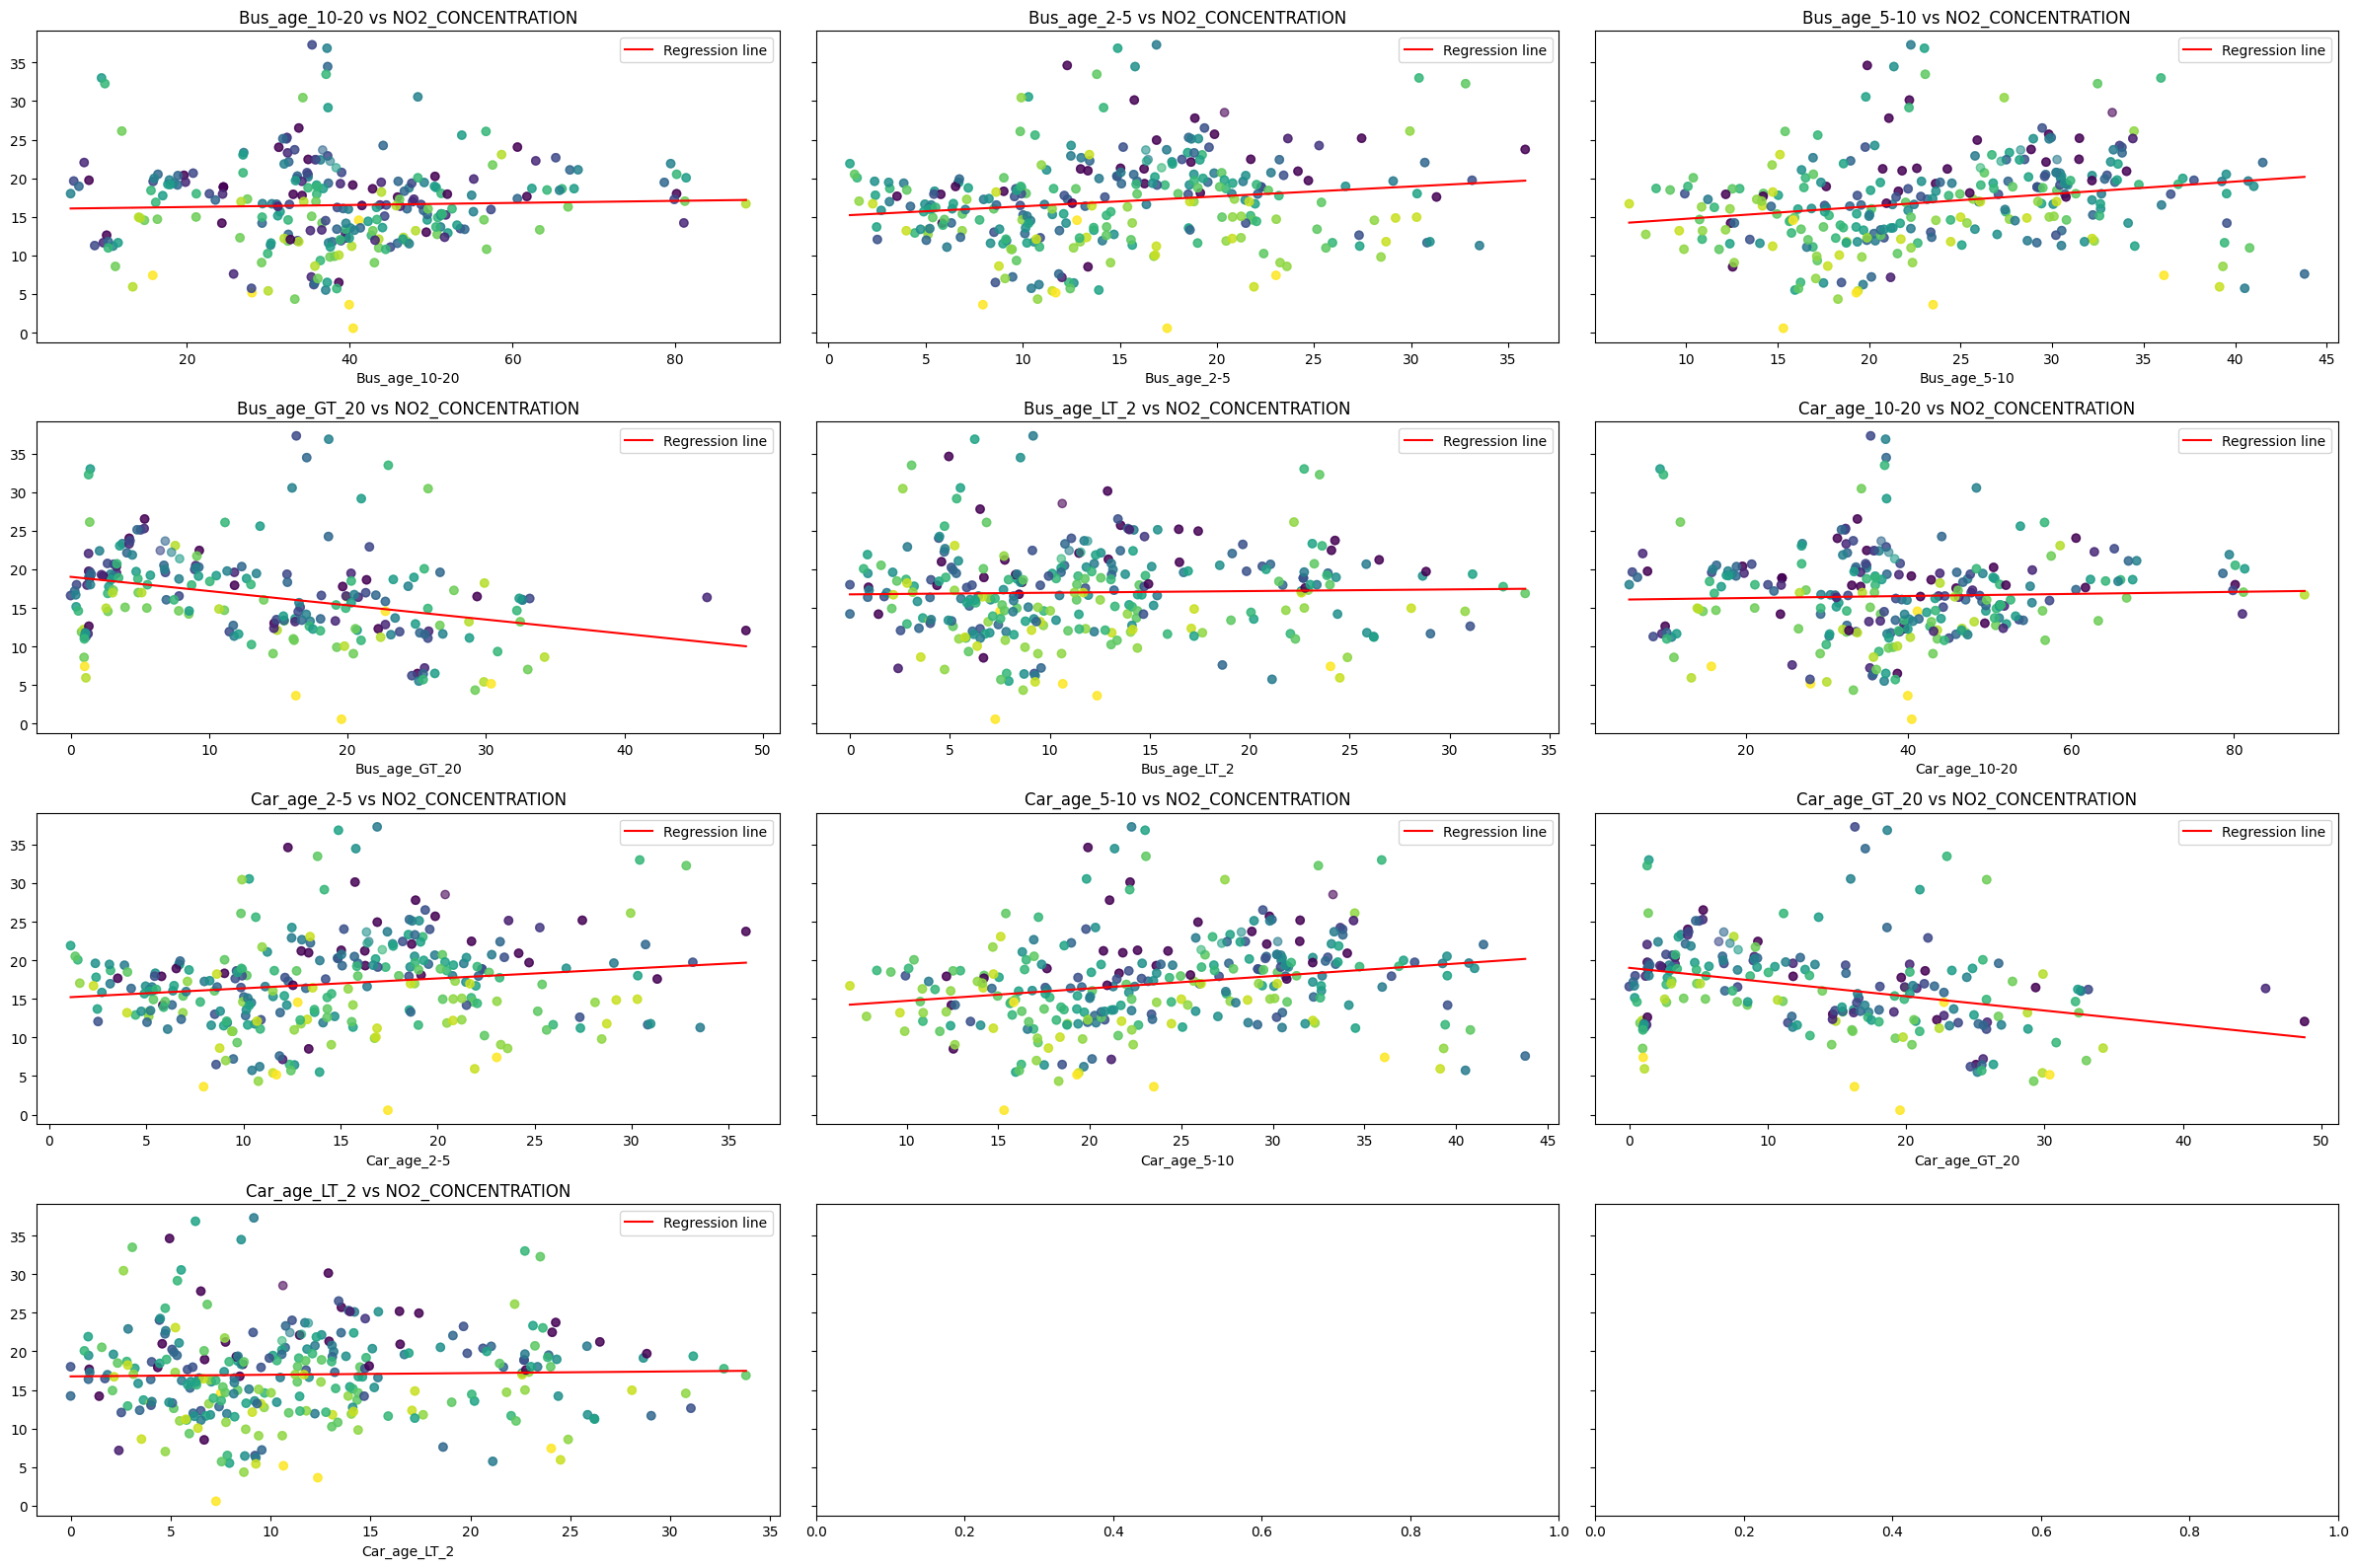

In [23]:
Age_transport = ['Bus_age_10-20', 'Bus_age_2-5', 'Bus_age_5-10', 'Bus_age_GT_20', 'Bus_age_LT_2', 'Car_age_10-20', 'Car_age_2-5', 'Car_age_5-10','Car_age_GT_20', 'Car_age_LT_2']

correlation_results_type_age['pm25'] = plot_pollutant_vs_x(df_all_clean_calc, "pm25_concentration", Age_transport)
correlation_results_type_age['pm10'] = plot_pollutant_vs_x(df_all_clean_calc, "pm10_concentration", Age_transport)
correlation_results_type_age['no2'] = plot_pollutant_vs_x(df_all_clean_calc, "no2_concentration", Age_transport)

### Modal share ###

Plotting pm25_concentration


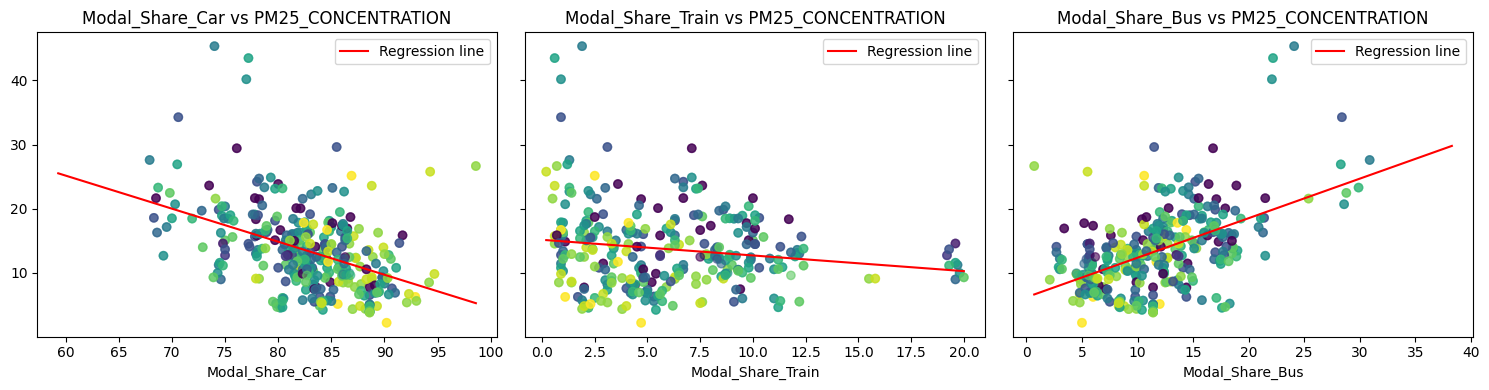

Plotting pm10_concentration


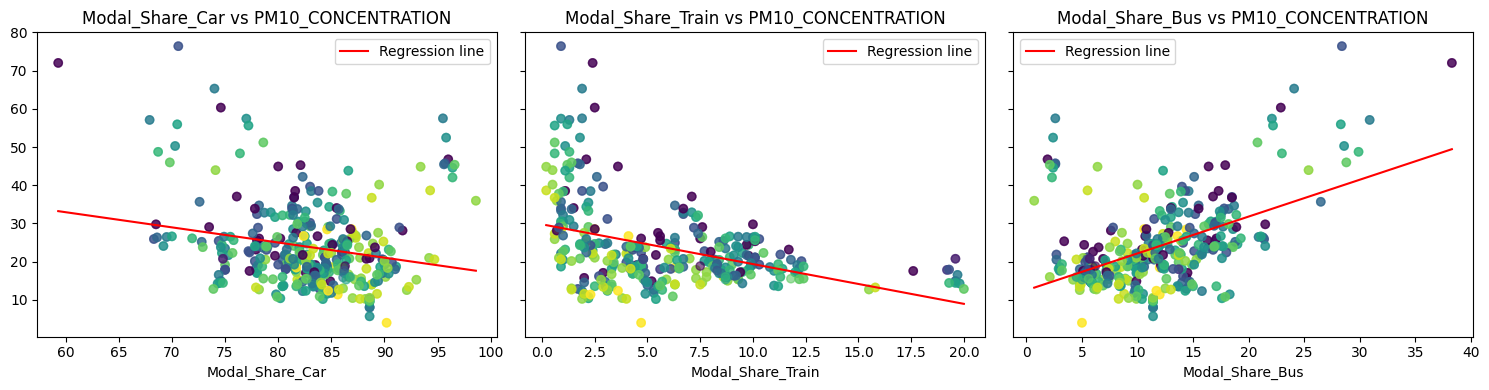

Plotting no2_concentration


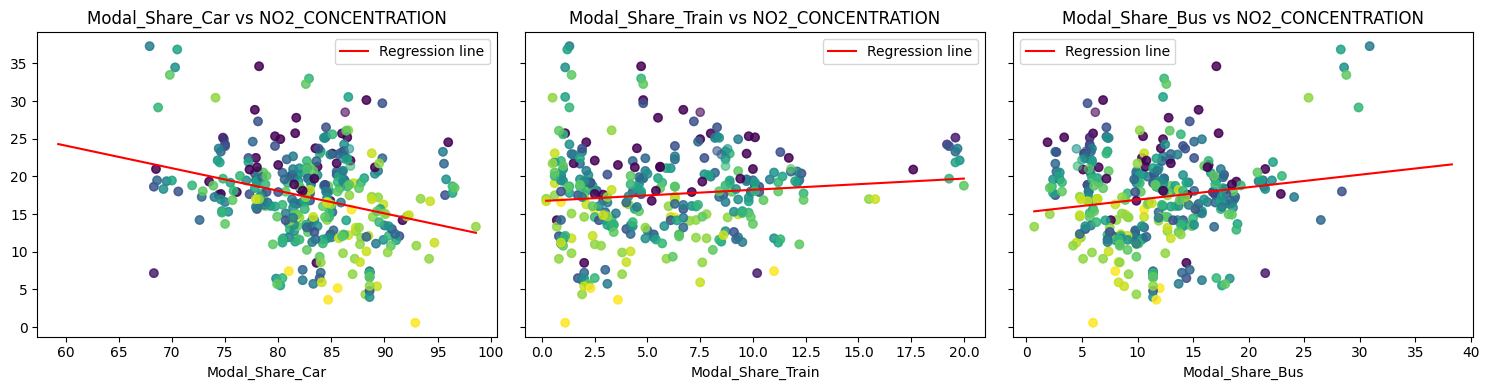

In [24]:
Modal_share_transport = ['Modal_Share_Car', 'Modal_Share_Train', 'Modal_Share_Bus']

correlation_results_modal_share['pm25'] = plot_pollutant_vs_x(df_all_clean_calc, "pm25_concentration", Modal_share_transport)
correlation_results_modal_share['pm10'] = plot_pollutant_vs_x(df_all_clean_calc, "pm10_concentration", Modal_share_transport)
correlation_results_modal_share['no2'] = plot_pollutant_vs_x(df_all_clean_calc, "no2_concentration", Modal_share_transport)

### Total Transport ###

Plotting pm25_concentration


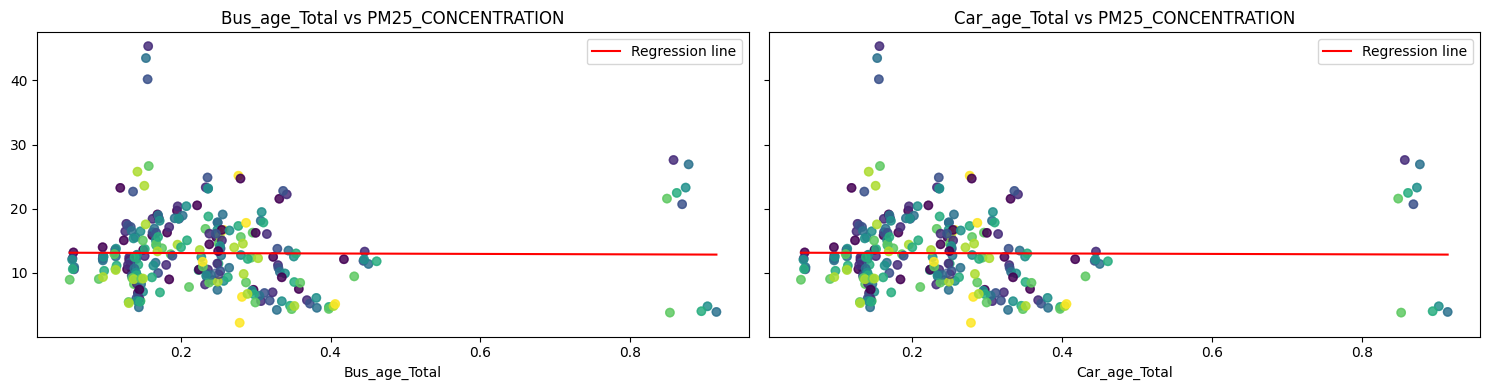

Plotting pm10_concentration


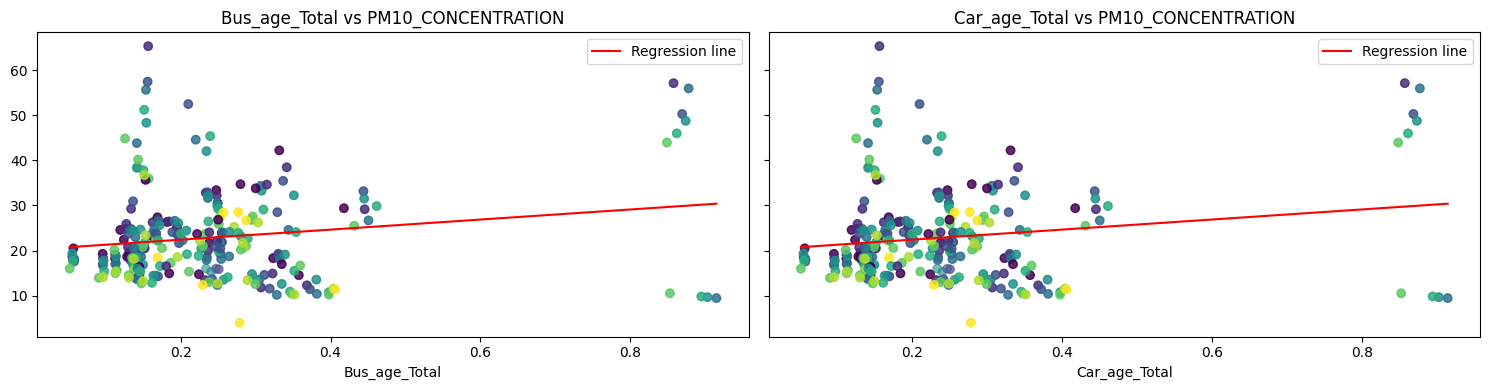

Plotting no2_concentration


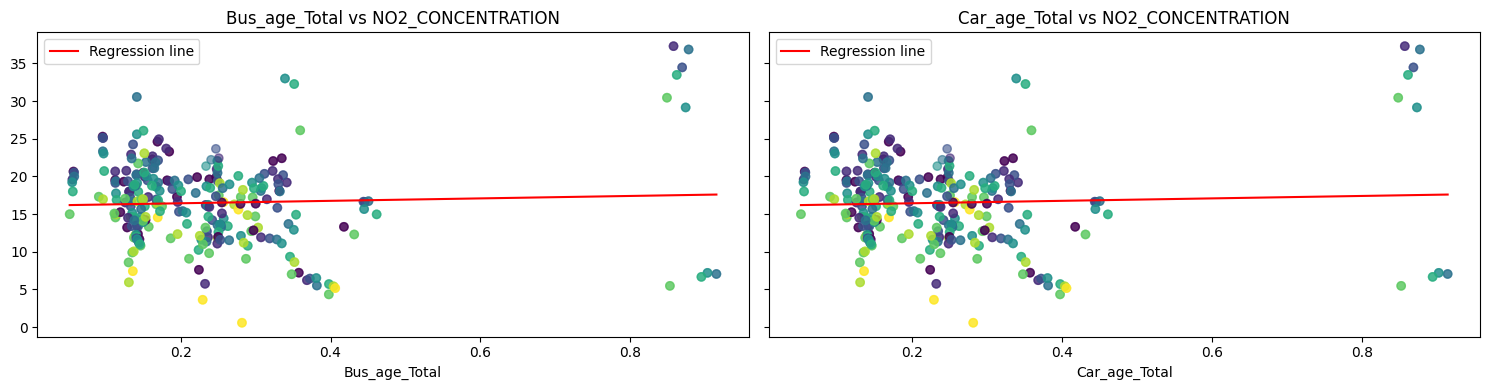

In [25]:
Total_transport = ['Bus_age_Total', 'Car_age_Total']

correlation_results_Total_transport['pm25'] = plot_pollutant_vs_x(df_all_clean_calc, "pm25_concentration", Total_transport)
correlation_results_Total_transport['pm10'] = plot_pollutant_vs_x(df_all_clean_calc, "pm10_concentration", Total_transport)
correlation_results_Total_transport['no2'] = plot_pollutant_vs_x(df_all_clean_calc, "no2_concentration", Total_transport)

### Population Age ###

Plotting pm25_concentration


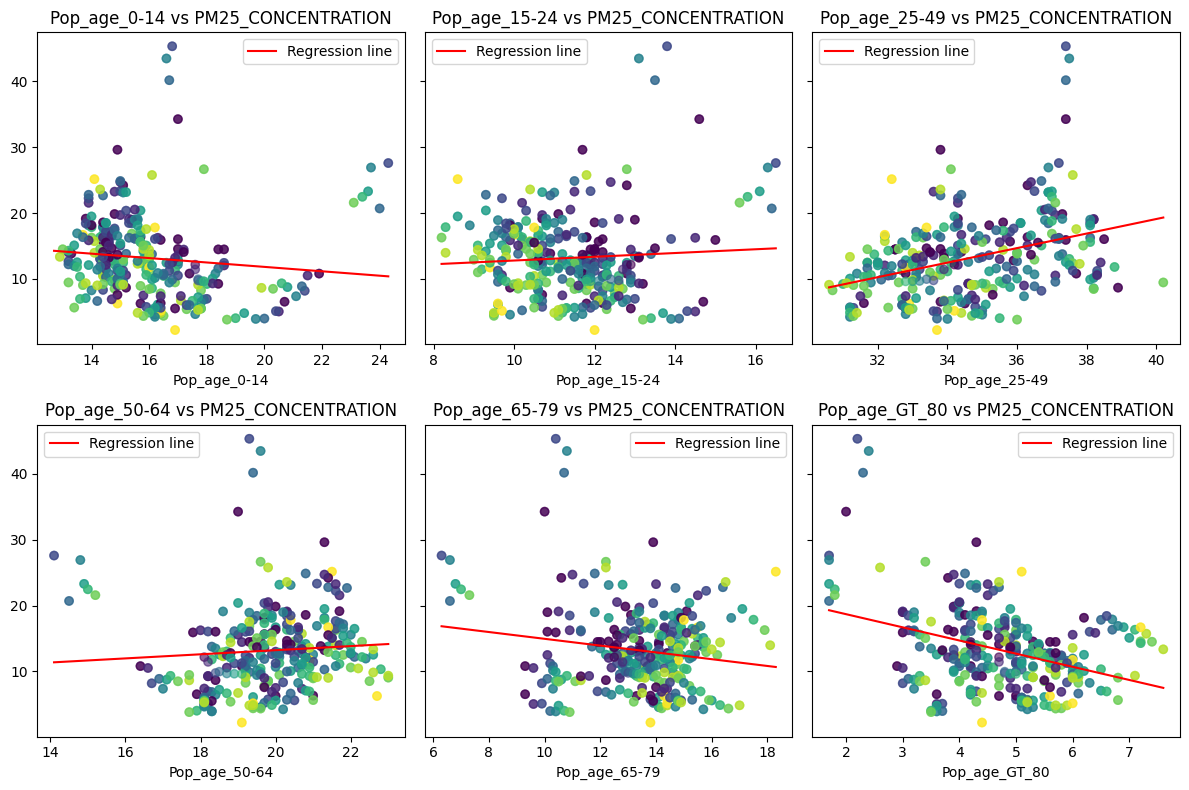

Plotting pm10_concentration


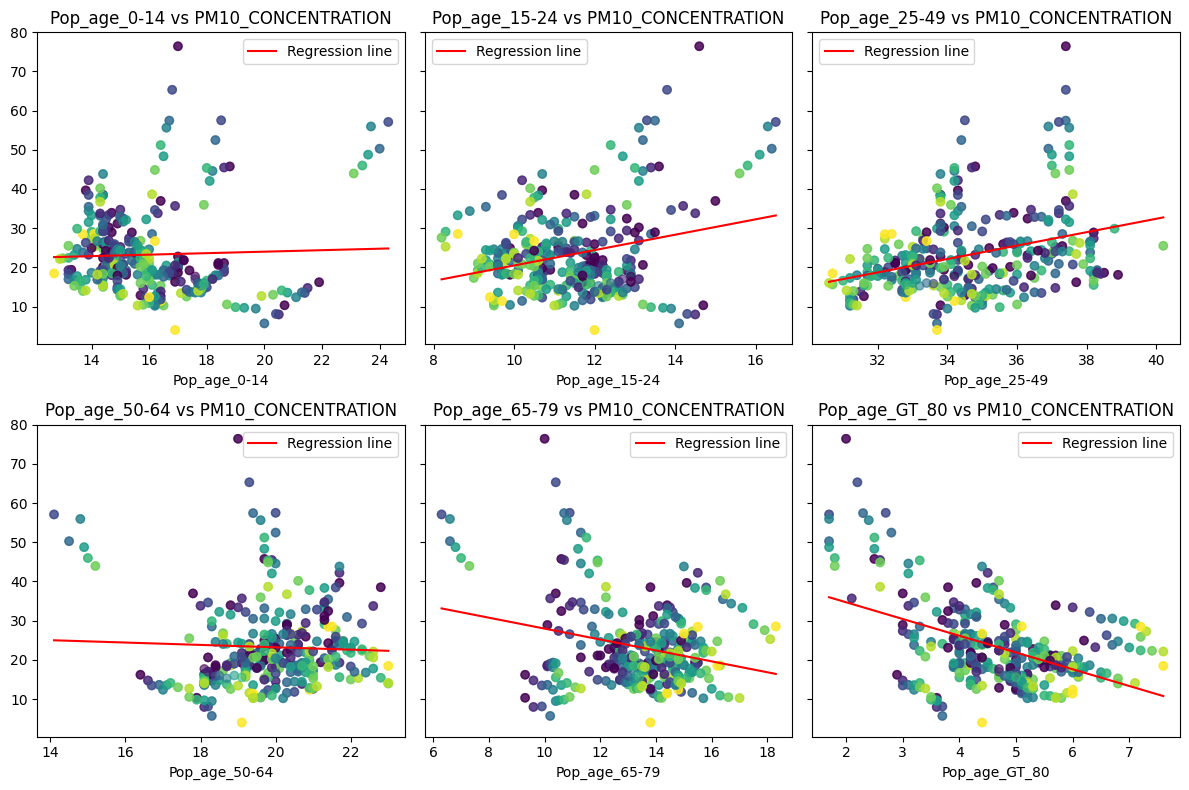

Plotting no2_concentration


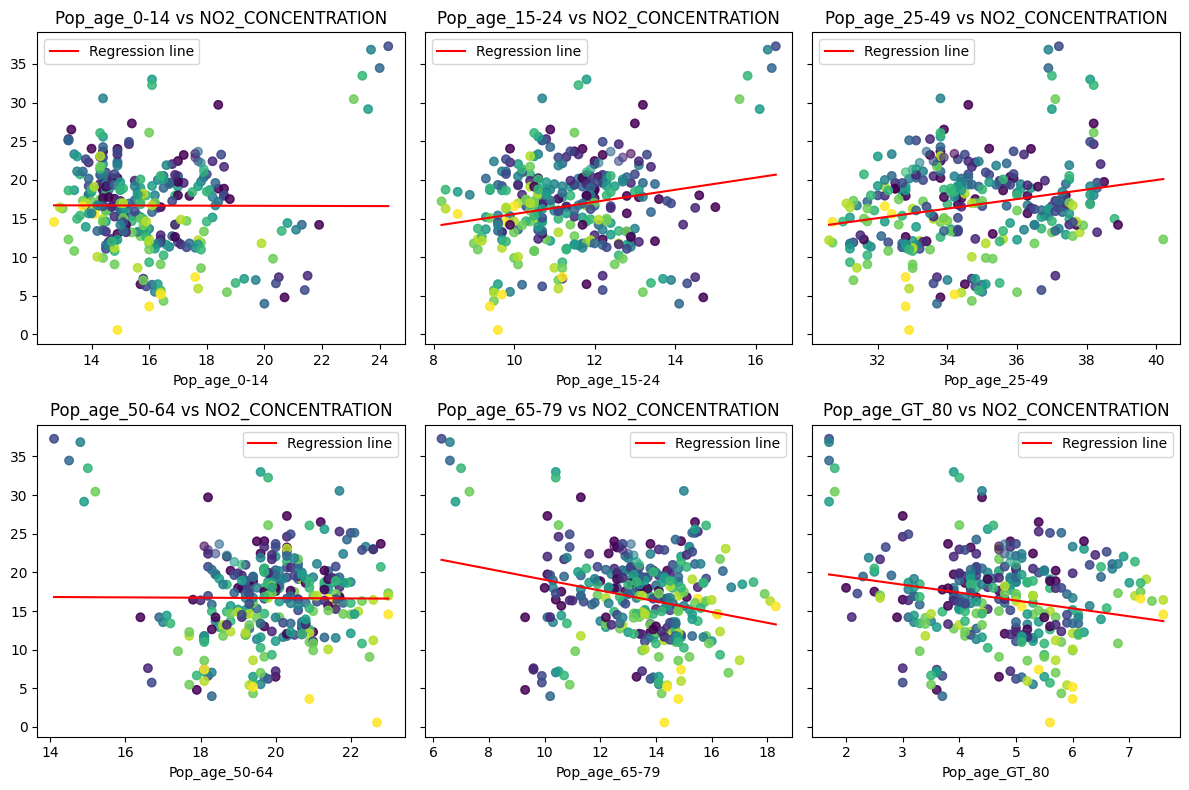

In [26]:
pop_age = ['Pop_age_0-14', 'Pop_age_15-24', 'Pop_age_25-49',
       'Pop_age_50-64', 'Pop_age_65-79', 'Pop_age_GT_80']

correlation_results_POP_Age['pm25'] = plot_pollutant_vs_x(df_all_clean_calc, "pm25_concentration", pop_age)
correlation_results_POP_Age['pm10'] = plot_pollutant_vs_x(df_all_clean_calc, "pm10_concentration", pop_age)
correlation_results_POP_Age['no2'] = plot_pollutant_vs_x(df_all_clean_calc, "no2_concentration", pop_age)

### GDP per capita, Population & Population Density ###

Plotting pm25_concentration


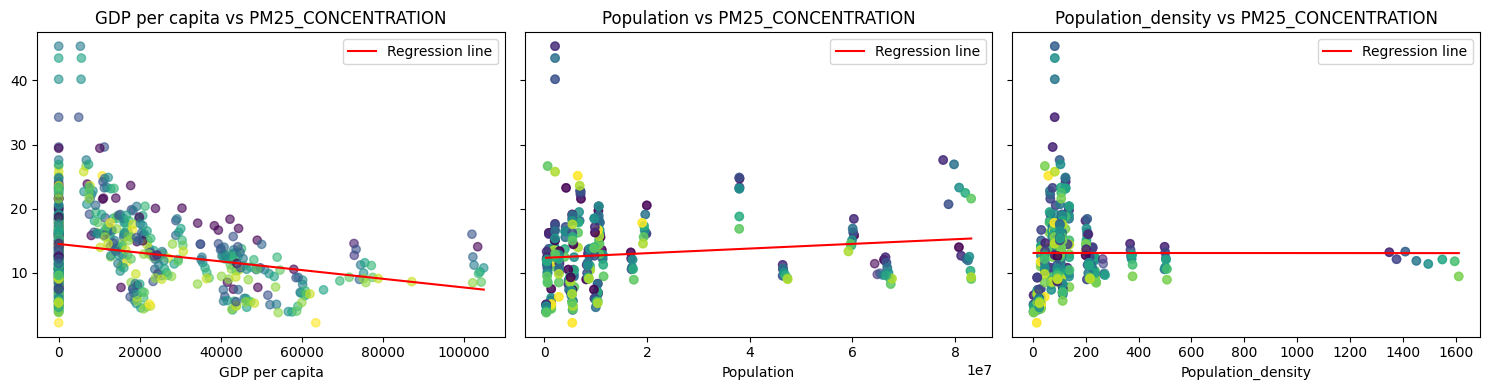

Plotting pm10_concentration


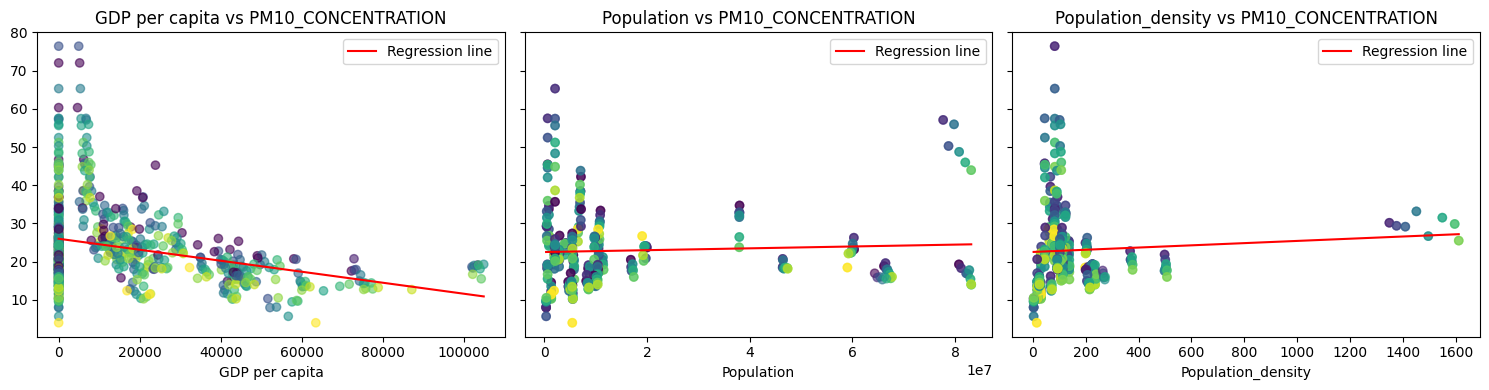

Plotting no2_concentration


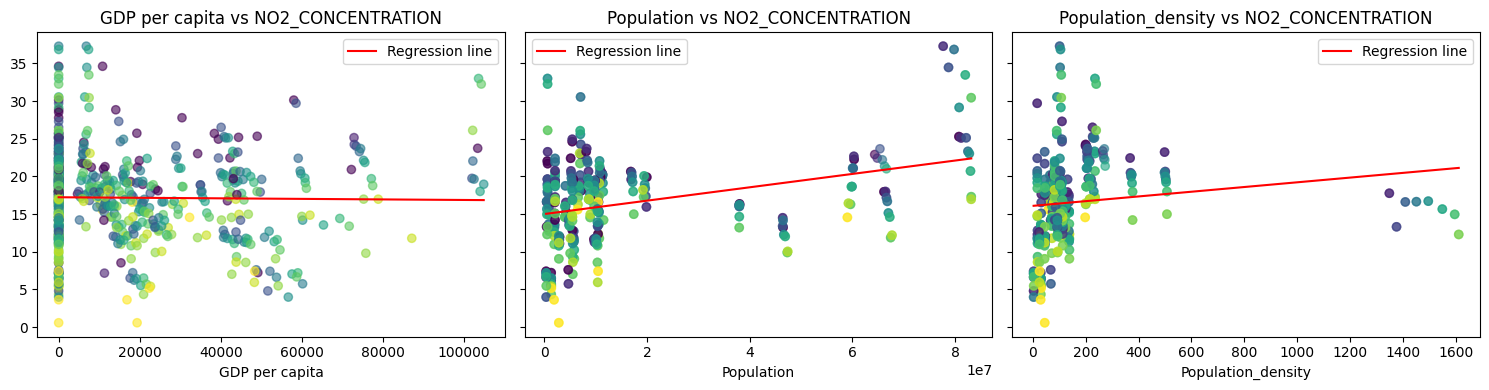

In [27]:
statistics = ['GDP per capita', 'Population', 'Population_density']

correlation_results_GDP['pm25'] = plot_pollutant_vs_x(df_all_clean_calc, "pm25_concentration", statistics)
correlation_results_GDP['pm10'] = plot_pollutant_vs_x(df_all_clean_calc, "pm10_concentration", statistics)
correlation_results_GDP['no2'] = plot_pollutant_vs_x(df_all_clean_calc, "no2_concentration", statistics)

## Correlation ##

In [ ]:
correlation_df = pd.concat([
    pd.DataFrame(correlation_results_propultion),
    pd.DataFrame(correlation_results_modal_share),
    pd.DataFrame(correlation_results_Total_transport),
    pd.DataFrame(correlation_results_POP_Age),
    pd.DataFrame(correlation_results_GDP)
])

correlation_df

pm25      pm10       no2
Bus_Diesel          0.290848  0.264365  0.300511
Bus_Petroleum       0.083875  0.045875 -0.034071
Bus_LPG             0.100999  0.012863  0.045795
Bus_Natural_Gas    -0.342950 -0.269872 -0.265951
Bus_Electricity    -0.147202 -0.176456 -0.227490
Car_Diesel          0.111440  0.136974 -0.062396
Car_Petroleum       0.046448  0.083729 -0.060092
Car_Renewable      -0.112163 -0.155462  0.086549
Modal_Share_Car    -0.440102 -0.208919 -0.286493
Modal_Share_Train  -0.162133 -0.403861  0.108240
Modal_Share_Bus     0.519984  0.496319  0.152367
Bus_age_Total      -0.008605  0.172967  0.044113
Car_age_Total      -0.008605  0.172967  0.044113
Pop_age_0-14       -0.111717  0.037240 -0.003143
Pop_age_15-24       0.066968  0.272024  0.200016
Pop_age_25-49       0.364978  0.330078  0.219051
Pop_age_50-64       0.075463 -0.042825 -0.005981
Pop_age_65-79      -0.163351 -0.261943 -0.240926
Pop_age_GT_80      -0.363314 -0.476811 -0.210113
GDP per capita     -0.245240 -0.290518 -0.013358
Population          0.136937  0.054224  0.355381
Population_density -0.000657  0.066760  0.132418

<Axes: title={'center': 'Correlation between Transport Factors and Air Pollutants'}, ylabel='Correlation Coefficient'>

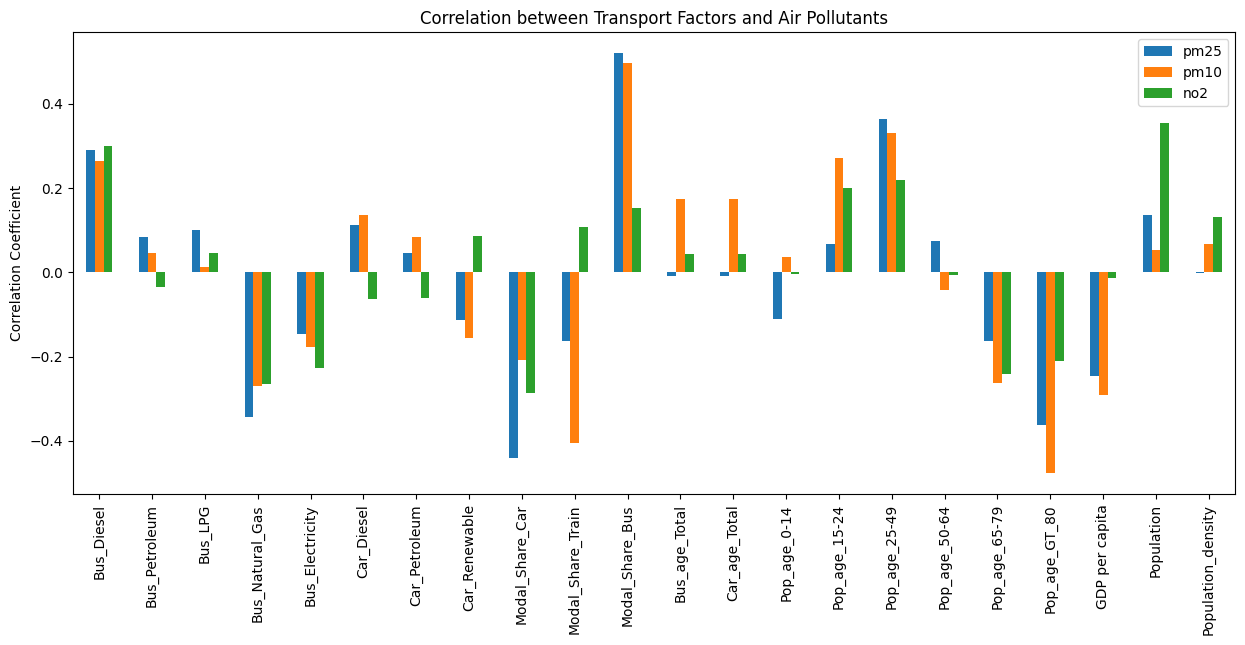

In [37]:
correlation_df.plot(kind='bar', figsize=(15, 6), ylabel='Correlation Coefficient', title='Correlation between Transport Factors and Air Pollutants')

## Modeling ##

In [6]:
# df_all_clean_calc.to_csv("data/EU_Data_clean.csv", index=False)

### Load Data ### 

In [7]:
df_total = pd.read_csv("data/EU_Data_clean.csv")
df_total

Country    Year  Bus_age_Total  Bus_age_10-20  Bus_age_2-5  \
0           Austria  2010.0            NaN            NaN    21.745439   
1           Austria  2010.0            NaN            NaN    21.745439   
2           Austria  2013.0            NaN      19.626266    23.436684   
3           Austria  2013.0            NaN      19.626266    23.436684   
4           Austria  2014.0       0.112662      19.812207    19.530516   
..              ...     ...            ...            ...          ...   
683  United Kingdom  2015.0       0.250867      35.838005    16.456459   
684  United Kingdom  2016.0       0.247021      36.663777    16.337461   
685  United Kingdom  2017.0       0.240617      37.590891    16.374849   
686  United Kingdom  2018.0       0.233864      38.321182    17.151429   
687  United Kingdom  2019.0            NaN            NaN          NaN   

     Bus_age_5-10  Bus_age_GT_20  Bus_age_LT_2  Bus_Diesel  Bus_Petroleum  \
0       31.467662            NaN     24.087894         NaN            NaN   
1       31.467662            NaN     24.087894         NaN            NaN   
2       32.999269       3.309322     20.628458   92.743788       0.020881   
3       32.999269       3.309322     20.628458   92.743788       0.020881   
4       33.427230       3.317684     23.912363   93.041210       0.031299   
..            ...            ...           ...         ...            ...   
683     30.267493       6.470964     10.967080         NaN            NaN   
684     28.278019       6.830960     11.889783         NaN            NaN   
685     27.205994       7.282620     11.545647         NaN            NaN   
686     26.081683       7.871476     10.574231         NaN            NaN   
687           NaN            NaN           NaN         NaN            NaN   

     ...  Pop_age_50-64  Pop_age_65-79  Pop_age_GT_80  Modal_Share_Bus  \
0    ...            NaN            NaN            NaN             10.4   
1    ...            NaN            NaN            NaN             10.4   
2    ...           19.7           13.1            5.0              9.9   
3    ...           19.7           13.1            5.0              9.9   
4    ...           20.0           13.3            5.0              9.9   
..   ...            ...            ...            ...              ...   
683  ...           18.4           13.0            4.8              5.2   
684  ...           18.5           13.1            4.8              4.5   
685  ...           18.7           13.2            4.9              5.0   
686  ...           18.9           13.3            4.9              4.6   
687  ...           19.1           13.4            5.0              5.6   

     Modal_Share_Car  Modal_Share_Train  pm10_concentration  \
0               77.9               11.7           23.169136   
1               77.9               11.7           23.169136   
2               77.8               12.3           20.139984   
3               77.8               12.3           20.139984   
4               77.9               12.2           18.240947   
..               ...                ...                 ...   
683             86.1                8.7           15.864308   
684             86.7                8.8           15.998788   
685             86.4                8.7           15.300830   
686             86.8                8.7           16.015115   
687             82.7               11.8           15.547070   

     pm25_concentration  no2_concentration  Bus_motor_Total  
0             18.357364          22.458091              NaN  
1             18.357364          22.458091              NaN  
2             15.660818          20.383615           9578.0  
3             15.660818          20.383615           9578.0  
4             12.987581          19.499727           9585.0  
..                  ...                ...              ...  
683            9.752607          22.425663              NaN  
684            9.949446          23.661133              

### PM10 ###

#### Prepare Data ####

In [8]:
target = "pm10_concentration"

# Drop rows where target is missing
df_pm10 = df_total.dropna(subset=[target])

# Features and target
X = df_pm10.drop(columns=["pm10_concentration", "pm25_concentration", "no2_concentration", "Year"])
y = df_pm10[target]

# One-hot encode 'Country'
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
country_encoded = encoder.fit_transform(X[["Country"]])
country_encoded_df = pd.DataFrame(country_encoded, columns=encoder.get_feature_names_out(["Country"]))

# Combine numeric features with encoded country
X_numeric = X.drop(columns=["Country"]).reset_index(drop=True)
X_encoded = pd.concat([X_numeric, country_encoded_df], axis=1)

#### Train Test ####

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


#### Define Model ####

In [39]:
# Define a coarse search space
param_grid_coarse = {
    "max_depth": [3, 6, 9],          # shallow, medium, deep trees
    "min_child_weight": [1, 5, 10],  # how many samples needed to split
    "subsample": [0.6, 0.8, 1.0],    # fraction of data for each tree
    "colsample_bytree": [0.6, 0.8, 1.0], # fraction of features per tree
    "learning_rate": [0.01, 0.1, 0.3],   # small, medium, large step sizes
    "n_estimators": [200, 500, 1000]     # number of trees
}

xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1)

grid_coarse = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid_coarse,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=2
)

grid_coarse.fit(X_encoded, y)

print("Best coarse params:", grid_coarse.best_params_)
print("Best RMSE (CV):", (-grid_coarse.best_score_)**0.5)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; tot

In [41]:
param_grid_fine = {
    "max_depth": [8, 9, 10],               # around 9
    "min_child_weight": [8, 10, 12],       # around 10
    "subsample": [0.5, 0.6, 0.7],          # around 0.6
    "colsample_bytree": [0.8, 0.9, 1.0],   # around 1.0
    "learning_rate": [0.2, 0.25, 0.3],     # around 0.3
    "n_estimators": [150, 200, 250]        # around 200
}

xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1)

grid_fine = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid_fine,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=2
)

grid_fine.fit(X_encoded, y)

print("Best fine params:", grid_fine.best_params_)
print("Best RMSE (CV):", (-grid_fine.best_score_)**0.5)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=150, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=150, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=150, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=150, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=150, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=150, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, min_child_weight=8, n_estimators=150, subsample=0.6; total time

In [ ]:
xgb_reg_pm10 = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,   
    learning_rate=0.1, 
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

#### Evaluate Model ####

In [29]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(y))  # out-of-fold predictions

for train_idx, valid_idx in kf.split(X_encoded):
    X_tr, X_val = X_encoded.iloc[train_idx], X_encoded.iloc[valid_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

    # Fit model on training fold
    xgb_reg_pm10.fit(X_tr, y_tr)

    # Predict on validation fold
    oof_preds[valid_idx] = xgb_reg_pm10.predict(X_val)

# Compute metrics on OOF predictions
cv_rmse = np.sqrt(mean_squared_error(y, oof_preds))
cv_r2 = r2_score(y, oof_preds)

print(f"\nOverall CV RMSE (OOF): {cv_rmse:.3f}")
print(f"Overall CV R² (OOF): {cv_r2:.3f}")


Overall CV RMSE (OOF): 2.065
Overall CV R² (OOF): 0.964


In [42]:
xgb_reg_pm10 = grid_fine.best_estimator_
xgb_reg_pm10.save_model("Model/xgb_pm10.json")

#### Feature Importance ####

<Figure size 1000x800 with 0 Axes>

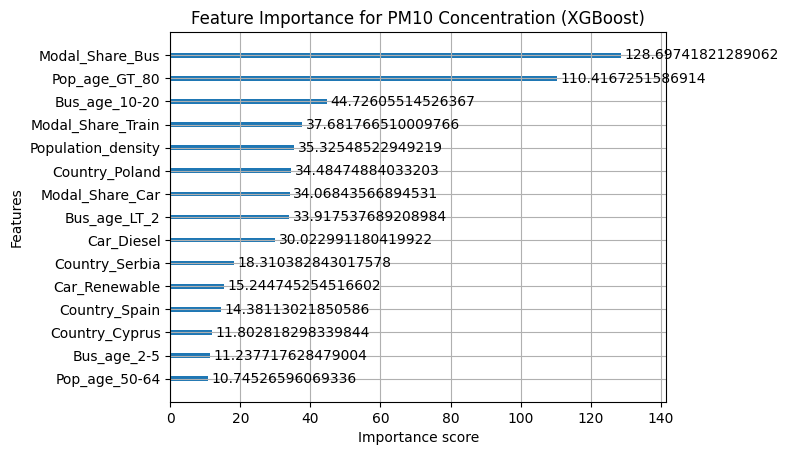

In [ ]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_reg_pm10, importance_type="gain", max_num_features=15)
plt.title("Feature Importance for PM10 Concentration (XGBoost)")
plt.show()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

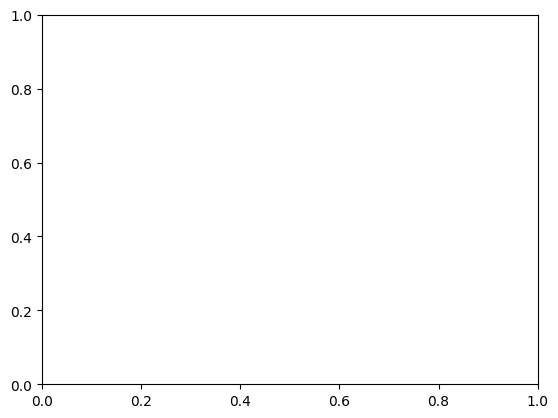

In [ ]:
# Has error
# xgb.plot_tree(xgb_reg_pm10, num_trees=0, rankdir="LR")
# plt.gcf().set_size_inches(30, 15)  # make it bigger if needed
# plt.show()

#### Plot Predicted vs Actual ####

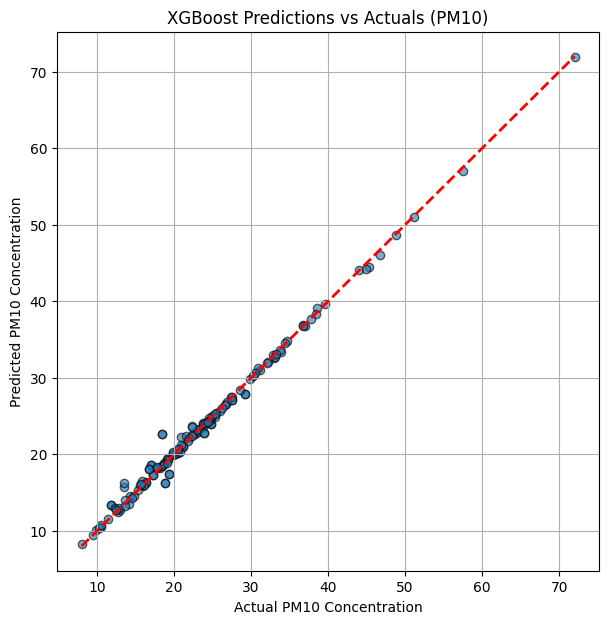

In [44]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)  # ideal line
plt.xlabel("Actual PM10 Concentration")
plt.ylabel("Predicted PM10 Concentration")
plt.title("XGBoost Predictions vs Actuals (PM10)")
plt.grid(True)
plt.show()


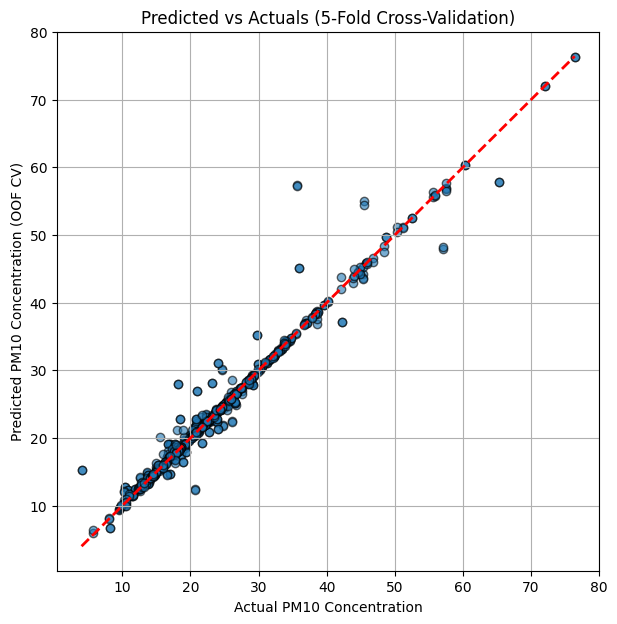

In [45]:
plt.figure(figsize=(7, 7))
plt.scatter(y, oof_preds, alpha=0.6, edgecolors="k")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("Actual PM10 Concentration")
plt.ylabel("Predicted PM10 Concentration (OOF CV)")
plt.title("Predicted vs Actuals (5-Fold Cross-Validation)")
plt.grid(True)
plt.show()

## Prectictions ##

In [3]:
def predict_pm10(model, encoder, input_dict):
    """
    Make a prediction for PM10 concentration from individual input values.
    
    Parameters
    ----------
    model : trained xgb.XGBRegressor
        The fitted XGBoost model.
    encoder : OneHotEncoder
        The fitted encoder for 'Country'.
    input_dict : dict
        A dictionary of input values, e.g.:
        {
            "Country": "Austria",
            "Year": 2015,
            "GDP per capita": 45000,
            "Modal_Share_Car": 75,
            "Modal_Share_Bus": 10,
            ...
        }
    """
    # Convert dict to DataFrame
    X_new = pd.DataFrame([input_dict])
    
    # Encode country
    country_encoded = encoder.transform(X_new[["Country"]])
    country_encoded_df = pd.DataFrame(
        country_encoded, 
        columns=encoder.get_feature_names_out(["Country"])
    )
    
    # Drop country and concat
    X_numeric = X_new.drop(columns=["Country"])
    X_encoded_new = pd.concat([X_numeric.reset_index(drop=True), country_encoded_df], axis=1)
    
    # Align columns with training data
    X_encoded_new = X_encoded_new.reindex(columns=X_encoded.columns, fill_value=0)
    
    # Predict
    prediction = model.predict(X_encoded_new)[0]
    return prediction

In [ ]:
example_input = {
    "Country": "Switzerland",
    "Bus_age_Total": 0.12,
    "Bus_age_10-20": 19.8,
    "Bus_age_2-5": 19.5,
    "Bus_age_5-10": 33.4,
    "Bus_age_GT_20": 3.3,
    "Bus_age_LT_2": 23.9,
    "Bus_Diesel": 93.0,
    "Bus_Petroleum": 0.03,
    "Bus_LPG": 0.0,
    "Bus_Natural_Gas": 0.5,
    "Bus_Electricity": 2.0,
    "Car_age_Total": 50.0,
    "Car_age_10-20": 20.0,
    "Car_age_2-5": 23.0,
    "Car_age_5-10": 30.0,
    "Car_age_GT_20": 10.0,
    "Car_age_LT_2": 17.0,
    "Car_Diesel": 60.0,
    "Car_Petroleum": 35.0,
    "Car_motor_Total": 3000,
    "Car_Renewable": 5.0,
    "GDP per capita": 45000,
    "Population": 8000000,
    "Population_density": 105,
    "Pop_age_0-14": 14.5,
    "Pop_age_15-24": 10.0,
    "Pop_age_25-49": 40.0,
    "Pop_age_50-64": 20.0,
    "Pop_age_65-79": 12.0,
    "Pop_age_GT_80": 3.5,
    "Modal_Share_Bus": 10.4,
    "Modal_Share_Car": 77.9,
    "Modal_Share_Train": 11.7,
    "Bus_motor_Total": 9500
}

prediction = predict_pm10(xgb_reg_pm10, encoder, example_input)
print(f"Predicted PM10 Concentration: {prediction:.2f}")

Predicted PM10 Concentration: 19.41


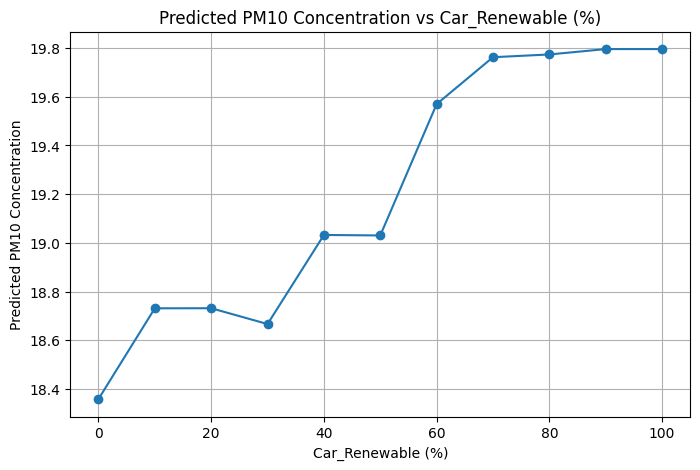

In [35]:
example_input = {
    "Country": "Switzerland",
    "Bus_age_Total": 0.12,
    "Bus_age_10-20": 19.8,
    "Bus_age_2-5": 19.5,
    "Bus_age_5-10": 33.4,
    "Bus_age_GT_20": 3.3,
    "Bus_age_LT_2": 23.9,
    "Bus_Diesel": 93.0,
    "Bus_Petroleum": 0.03,
    "Bus_LPG": 0.0,
    "Bus_Natural_Gas": 0.5,
    "Bus_Electricity": 2.0,
    "Car_age_Total": 50.0,
    "Car_age_10-20": 20.0,
    "Car_age_2-5": 23.0,
    "Car_age_5-10": 30.0,
    "Car_age_GT_20": 10.0,
    "Car_age_LT_2": 17.0,
    "Car_Diesel": 100-value,
    "Car_Petroleum": 0,
    "Car_motor_Total": 3000,
    "Car_Renewable": value,
    "GDP per capita": 45000,
    "Population": 8_000_000,
    "Population_density": 105,
    "Pop_age_0-14": 14.5,
    "Pop_age_15-24": 10.0,
    "Pop_age_25-49": 40.0,
    "Pop_age_50-64": 20.0,
    "Pop_age_65-79": 12.0,
    "Pop_age_GT_80": 3.5,
    "Modal_Share_Bus": 10.4,
    "Modal_Share_Car": 77.9,
    "Modal_Share_Train": 11.7,
    "Bus_motor_Total": 9500
}

car_renewable_values = []
pm10_predictions = []

for value in range(0, 101, 10):
    example_input["Car_Renewable"] = value
    example_input["Car_Diesel"] = 0
    example_input["Car_Petroleum"] = 100-value
    prediction = predict_pm10(xgb_reg_pm10, encoder, example_input)
    car_renewable_values.append(value)
    pm10_predictions.append(prediction)

plt.figure(figsize=(8, 5))
plt.plot(car_renewable_values, pm10_predictions, marker='o')
plt.xlabel("Car_Renewable (%)")
plt.ylabel("Predicted PM10 Concentration")
plt.title("Predicted PM10 Concentration vs Car_Renewable (%)")
plt.grid(True)
plt.show()
